# Language in Space

## Session 07: Vector data operations

### Gerhard Jäger

December 9, 2021


In [1]:
options(repr.plot.width=12, repr.plot.height=9)


In [2]:
library(tidyverse)
library(sf)
library(spData)


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.0, GDAL 3.2.2, PROJ 7.2.1



## Spatial data operations

When working with spatial data sets, we want to use the spatial information for various data processing tasks. 

### Examples

- Join a tibble with polygon geometries to a tibble with point geometries such that each polygon is joined with each point within its area.

- When summarizing observations with polygon geometries, assign the union of the geometries to the aggregated observations.

- Find all observations that are within 100 km distance of a given point.

- Form the intersection of polygons (e.g., to crop a map).

- Change the shape and location of geometries, e.g. shifting, scaling, mirroring or rotating them.



### Topological relations

Topological relations are relations between geometric objects that remain constant under continuous transformations like shifting, scaling, rotating or deforming.


**Example**

In [3]:
# create a polygon
a_poly = st_polygon(list(rbind(c(-1, -1), c(1, -1), c(1, 1), c(-1, -1))))
a = st_sfc(a_poly)

# create a second polygon

b_poly = st_polygon(list(rbind(c(0.1, -1), c(0.1, 0), c(.9, 0), c(.9, -1), c(.1, -1))))
b = st_sfc(b_poly)

# create a line
l_line = st_linestring(x = matrix(c(-1, -1, -0.5, 1), ncol = 2))
l = st_sfc(l_line)
# create points
p_matrix = matrix(c(0.5, 1, -1, 0, 0, 1, 0.5, 1), ncol = 2)
p_multi = st_multipoint(x = p_matrix)
p = st_cast(st_sfc(p_multi), "POINT")

exampleGeometries <- st_sf(
    names = c("a", "b", "l", "p1", "p2", "p3", "p4"),
    type = c("polygon", "polygon", "line", "point", "point", "point", "point"),
    c(a, b, l, p)
)
exampleGeometries

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,names,type,c.a..b..l..p.
,<chr>,<chr>,<GEOMETRY>
1,a,polygon,"POLYGON ((-1 -1, 1 -1, 1 1,..."
2,b,polygon,"POLYGON ((0.1 -1, 0.1 0, 0...."
3,l,line,"LINESTRING (-1 -0.5, -1 1)"
4,p1,point,POINT (0.5 0)
5,p2,point,POINT (1 1)
6,p3,point,POINT (-1 0.5)
7,p4,point,POINT (0 1)


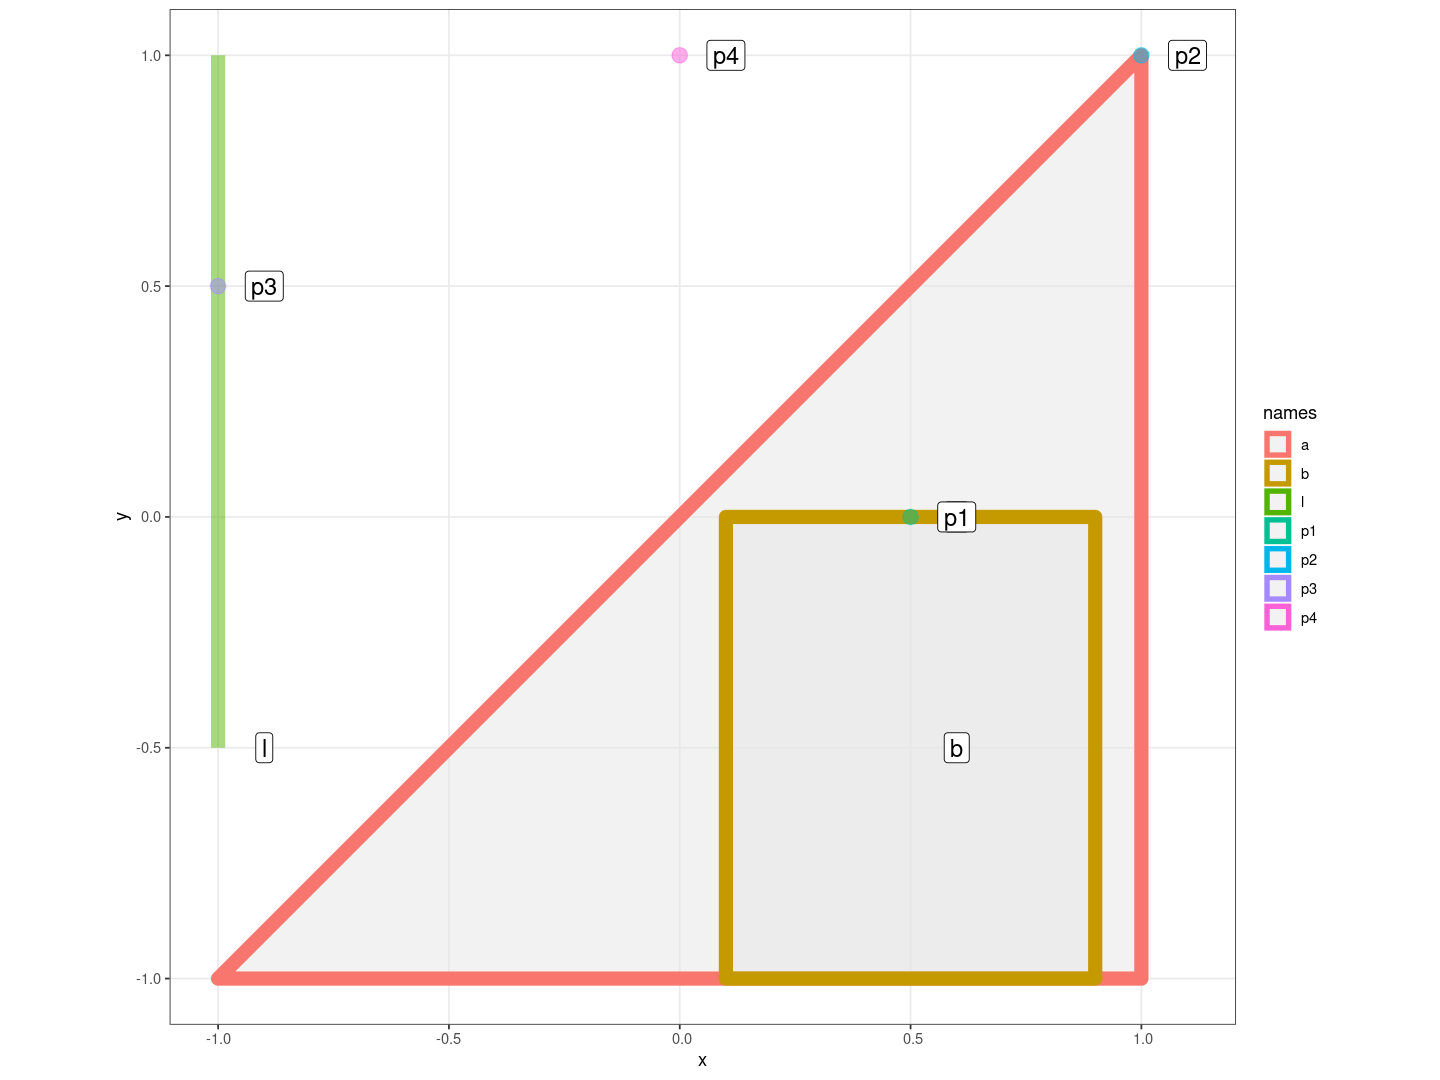

In [4]:
exampleGeometries %>%
    ggplot() +
    theme_bw() +
    geom_sf(aes(col=names), alpha=0.5, size=4) +
    geom_sf_label(aes(label=names), size=5, nudge_x=.1)  


Which points intersect with the large polygon?

In [5]:
st_intersects(p, a, sparse=F)

TRUE
TRUE
FALSE
FALSE


Note that the result for `p2` is `TRUE`, even though the point is at the boundary of the polygon.

The two polygons of course also intersect.

In [6]:
st_intersects(b, a, sparse=F)

TRUE


The opposite of `sp_intersects` is `sp_disjoint`.

In [7]:
st_disjoint(p, a, sparse = F)


FALSE
FALSE
TRUE
TRUE


`st_within` returns `TRUE` only in case of complete inclusion. (NB: This is not a topological relation.)

In [8]:
st_within(p, a, sparse=F)

TRUE
FALSE
FALSE
FALSE


In [9]:
st_within(p, b, sparse=F)

FALSE
FALSE
FALSE
FALSE


`st_touches` is true if a point or line or border of a polygon includes the other object.

In [10]:
st_touches(p, a, sparse=F)

FALSE
TRUE
FALSE
FALSE


`st_is_within_distance` does what its name says.

In [11]:
st_is_within_distance(p, a, dist = 0.9, sparse=F)

TRUE
TRUE
FALSE
TRUE


## Geometric operations on vector data

Geometric operations create geometric objects out of geometric objects. They include

- simplification
- finding centroids of areas
- creating buffers around geometries
- affine transformations (shifting, scaling, rotating)
- clipping
- geometric union
- Voronoi tesselation

### Geometric simplification

Linestrings and polygons may consists of many segments, not all of which are needed for a specific purpose.

Consider this representation of the river Seine with tributuaries from `spData`:

In [12]:
seine

name,geometry
<chr>,<MULTILINESTRING [m]>
Marne,MULTILINESTRING ((879955.3 ...
Seine,MULTILINESTRING ((828893.6 ...
Yonne,MULTILINESTRING ((773482.1 ...


In [13]:
seine %>%
    st_geometry() %>%
    st_cast("POINT")

POINT (879955.3 6755725)

POINT (878440.9 6755688)

POINT (876653.8 6756227)

POINT (874212.2 6757918)

POINT (873572.2 6758374)



Geometry set for 658 features 
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 518344.7 ymin: 6660431 xmax: 879955.3 ymax: 6938864
Projected CRS: RGF93 / Lambert-93
First 5 geometries:

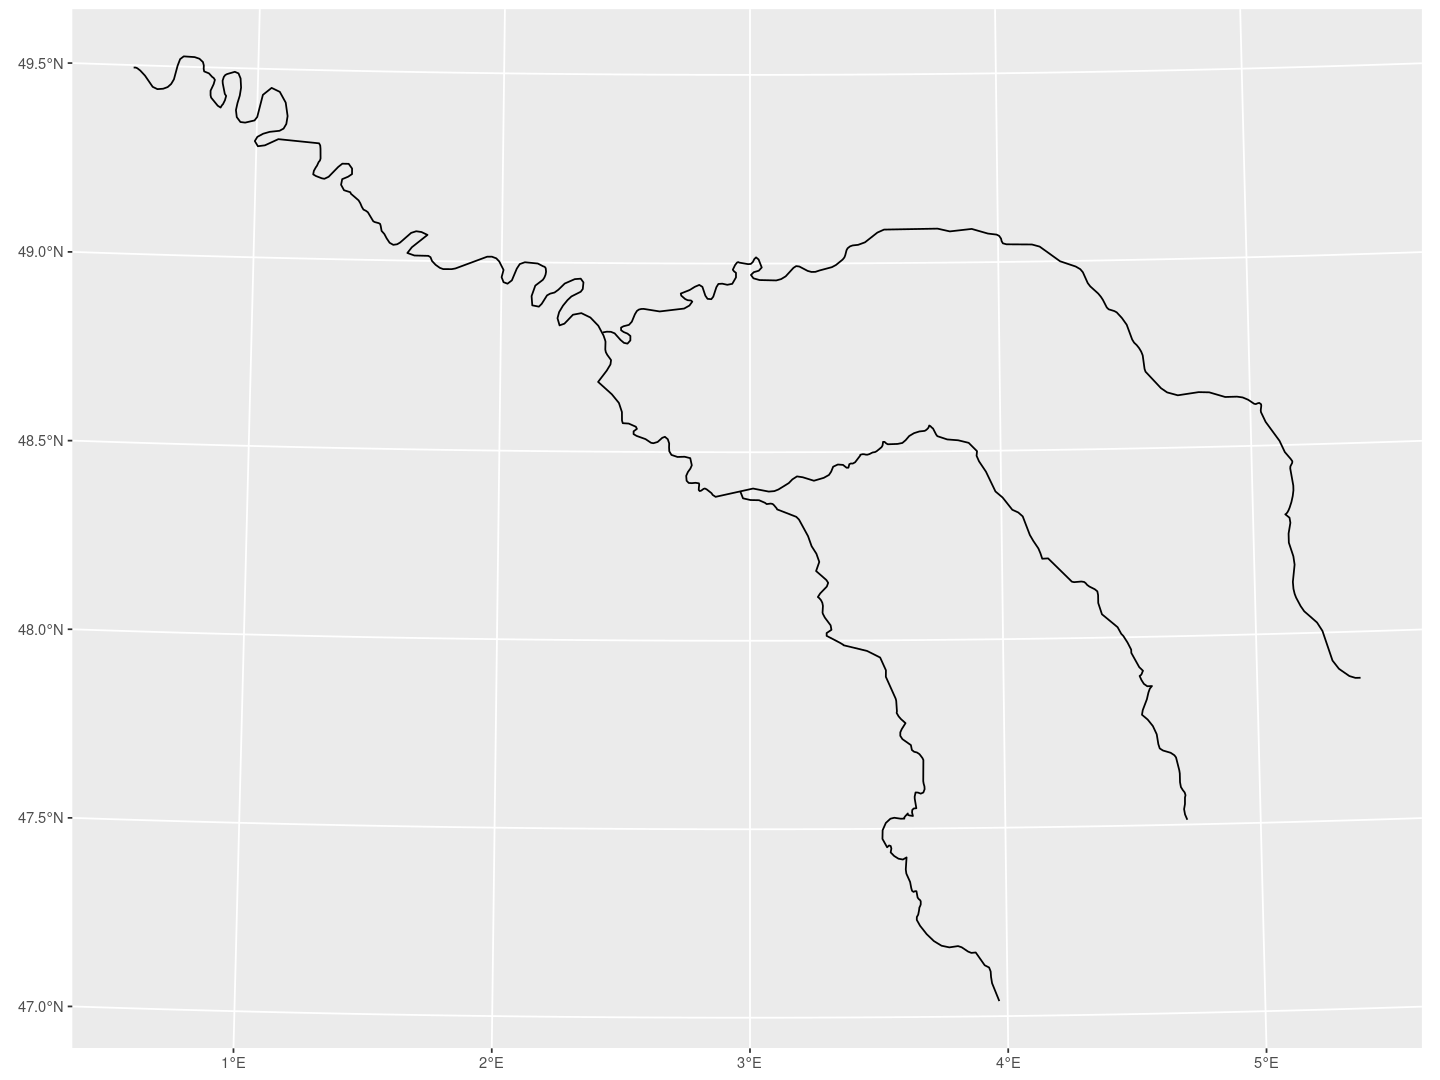

In [14]:
seine %>%
    ggplot() +
    geom_sf()

With `st_simplify` we can remove points while preserving the overall shape. The `dTolarance` argument determines how strongly the shape is simplified.

In [15]:
dt = 2000 # units are metre
seine %>%
    st_simplify(dTolerance=dt) %>%
    st_geometry() %>%
    st_cast("POINT") %>%
    length()

[1] 108

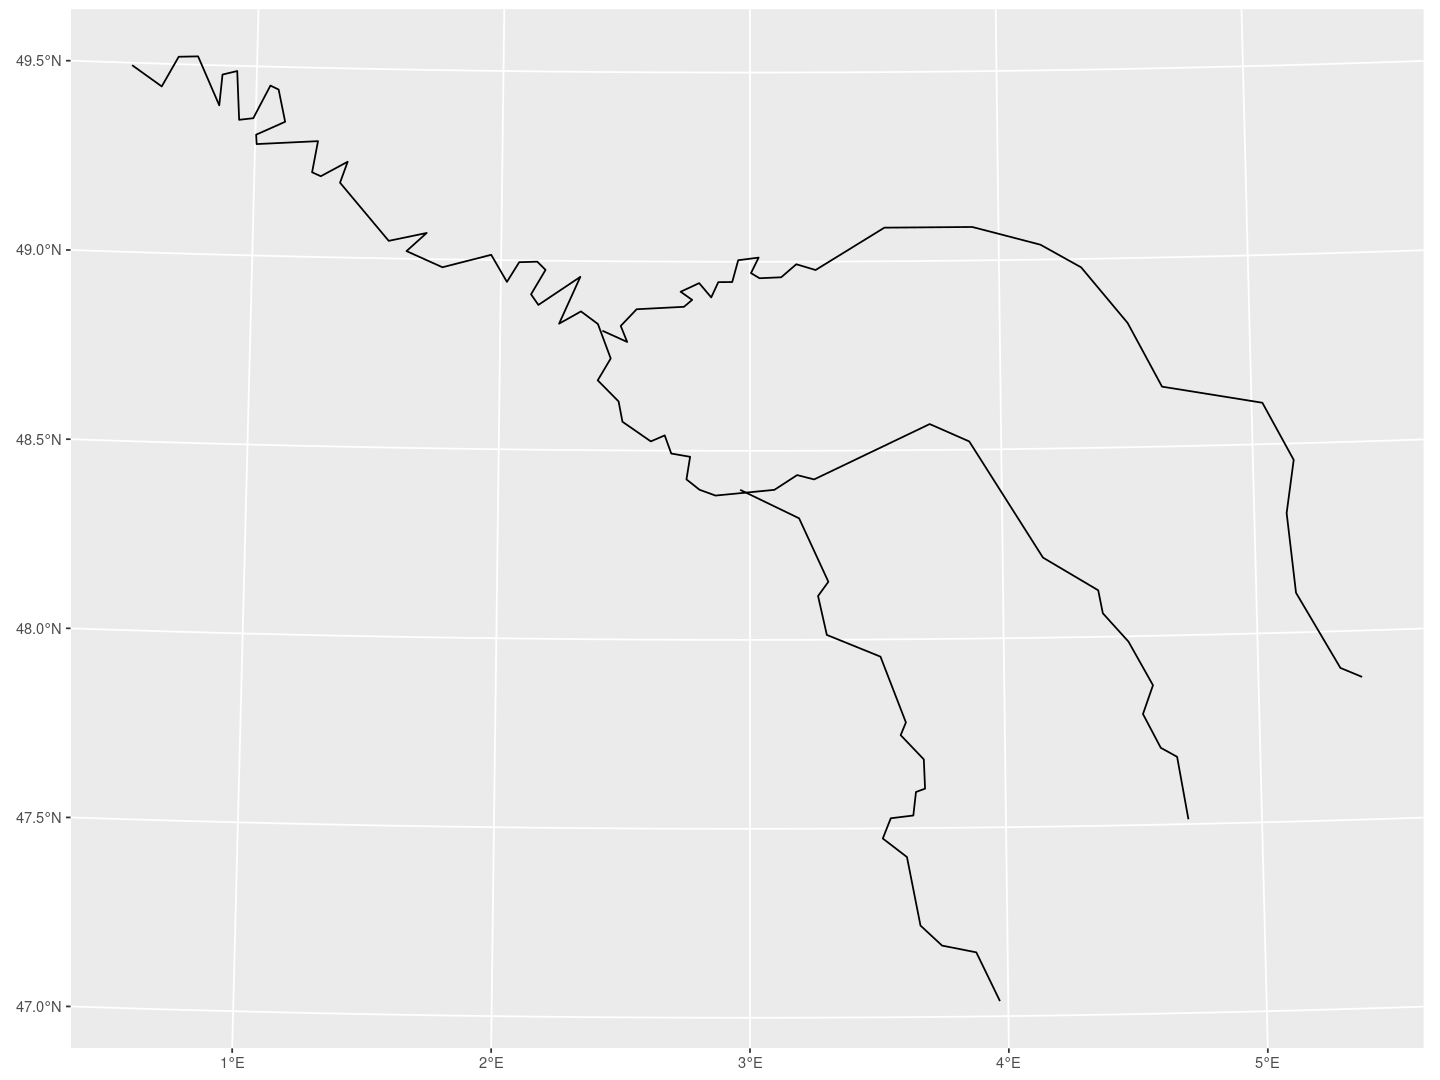

In [16]:
seine %>%
    st_simplify(dTolerance=dt) %>%
    ggplot() +
    geom_sf()

### Simplification of polygons

`st_simplify` also applies to polygons. There is a catch though.



In [17]:
us_states_wu <- us_states %>%
    mutate(AREA = as.numeric(AREA))

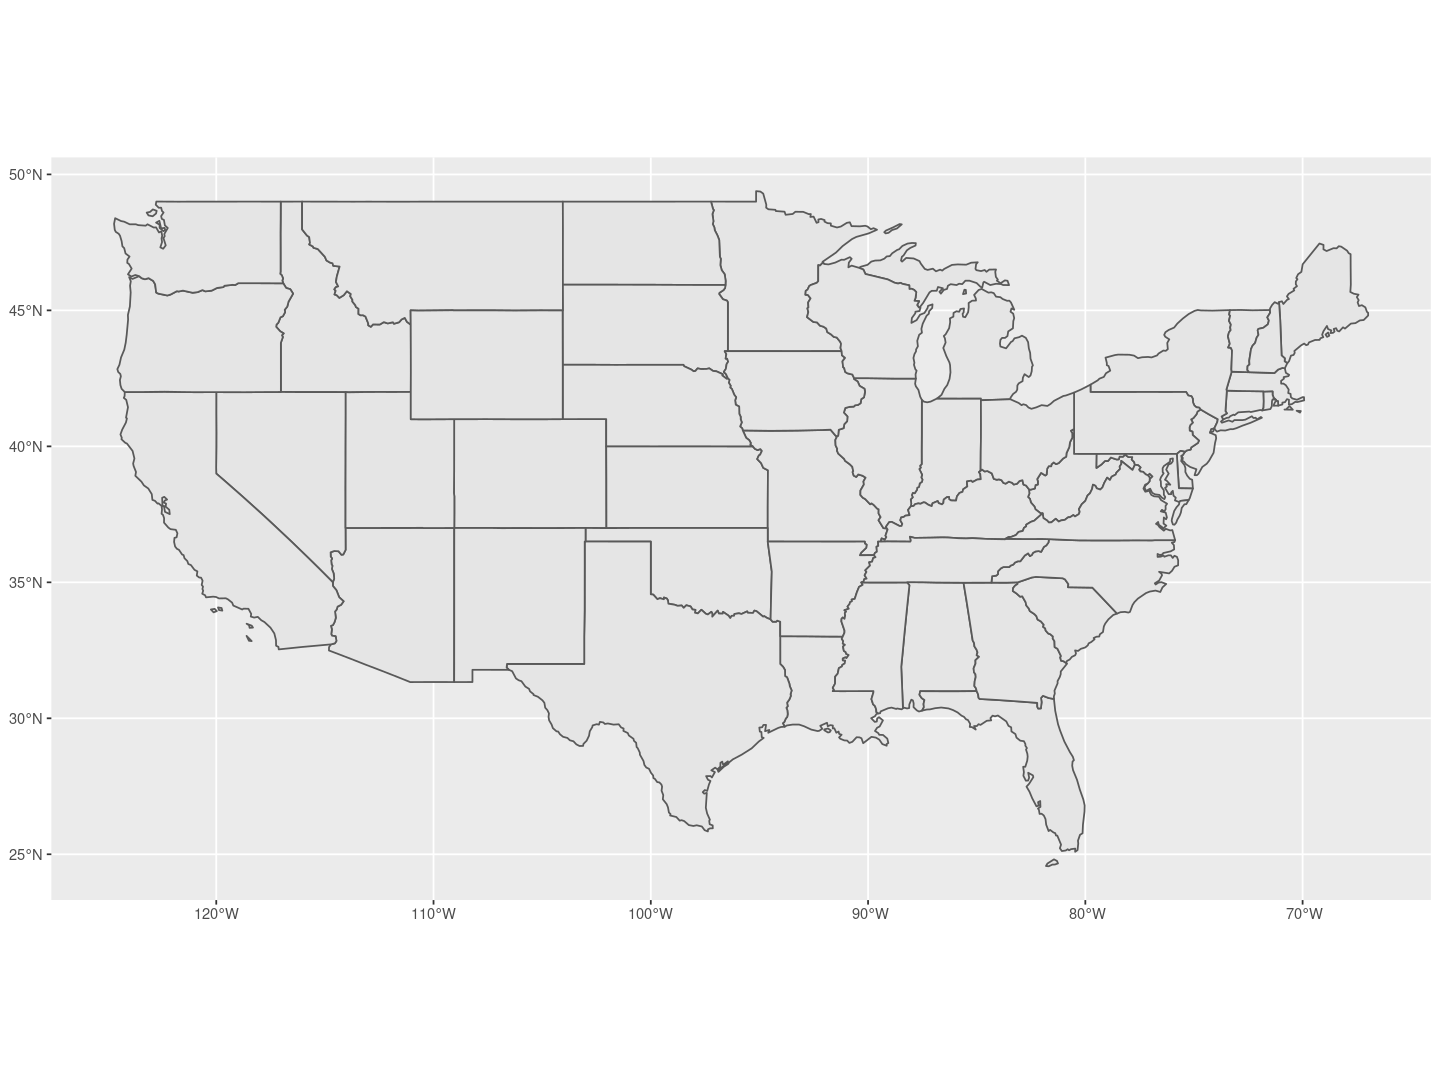

In [18]:
us_states_wu %>%
    ggplot() +
    geom_sf()

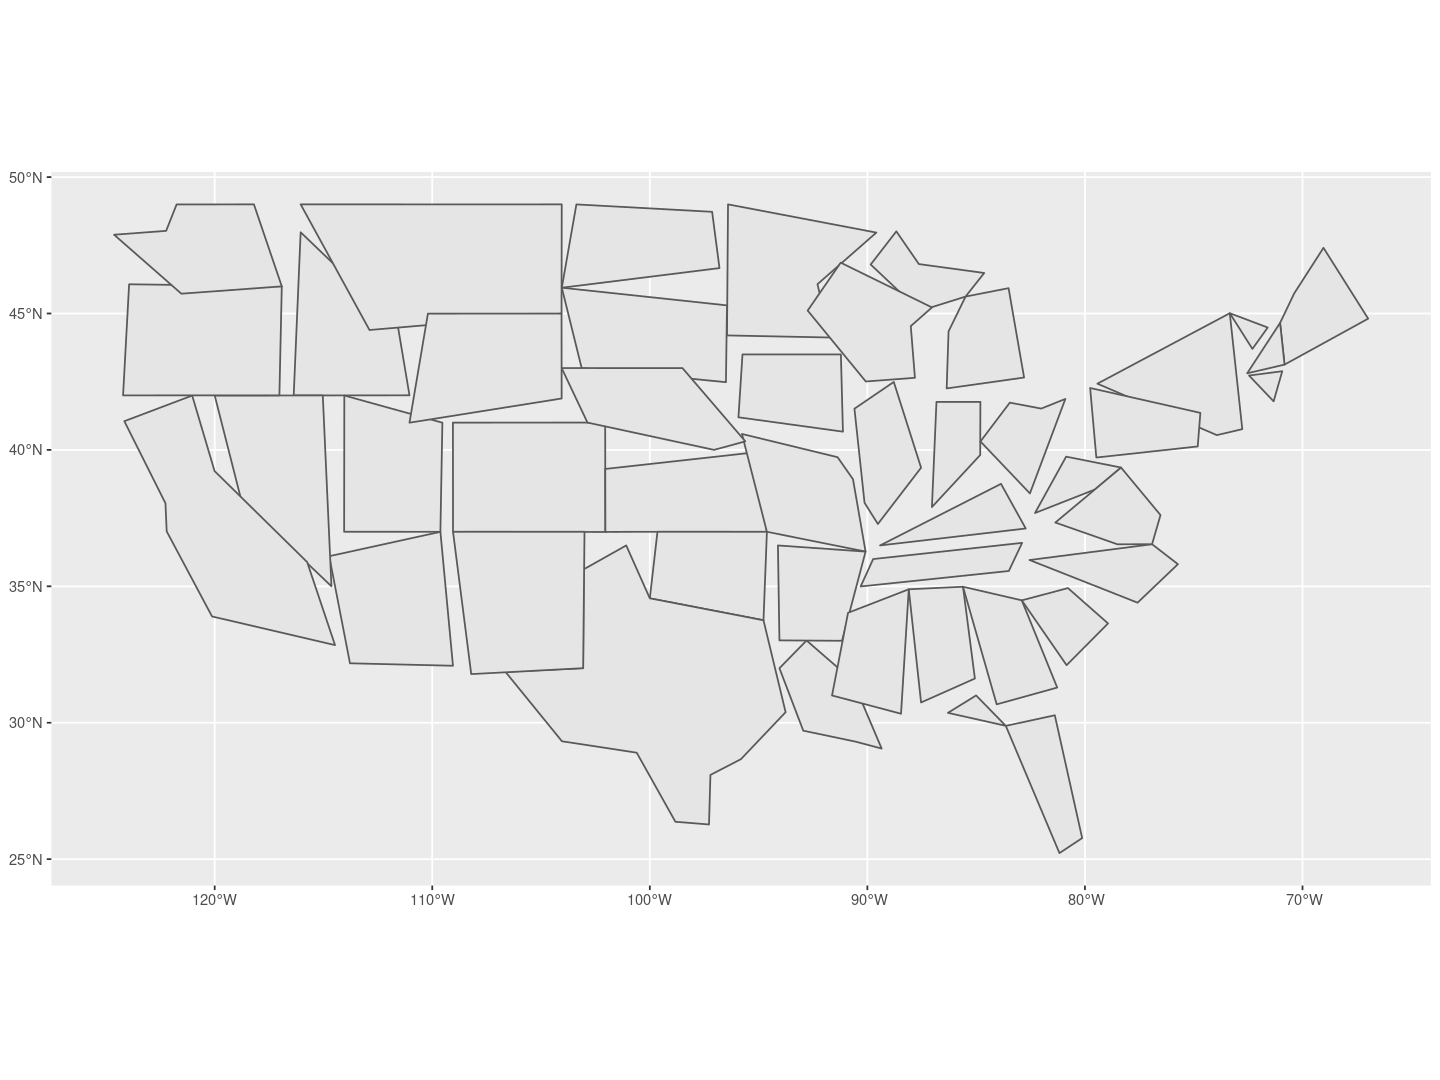

In [19]:

us_states_wu %>%
    st_simplify(dTolerance=100000) %>%
    ggplot() +
    geom_sf()

`st_simplify` simplifies each geometry individually, without regard of shared borders. 

An alternative is the function `ms_simplify` from the package `rmapshaper`.

Registered S3 method overwritten by 'geojsonlint':
  method         from 
  print.location dplyr



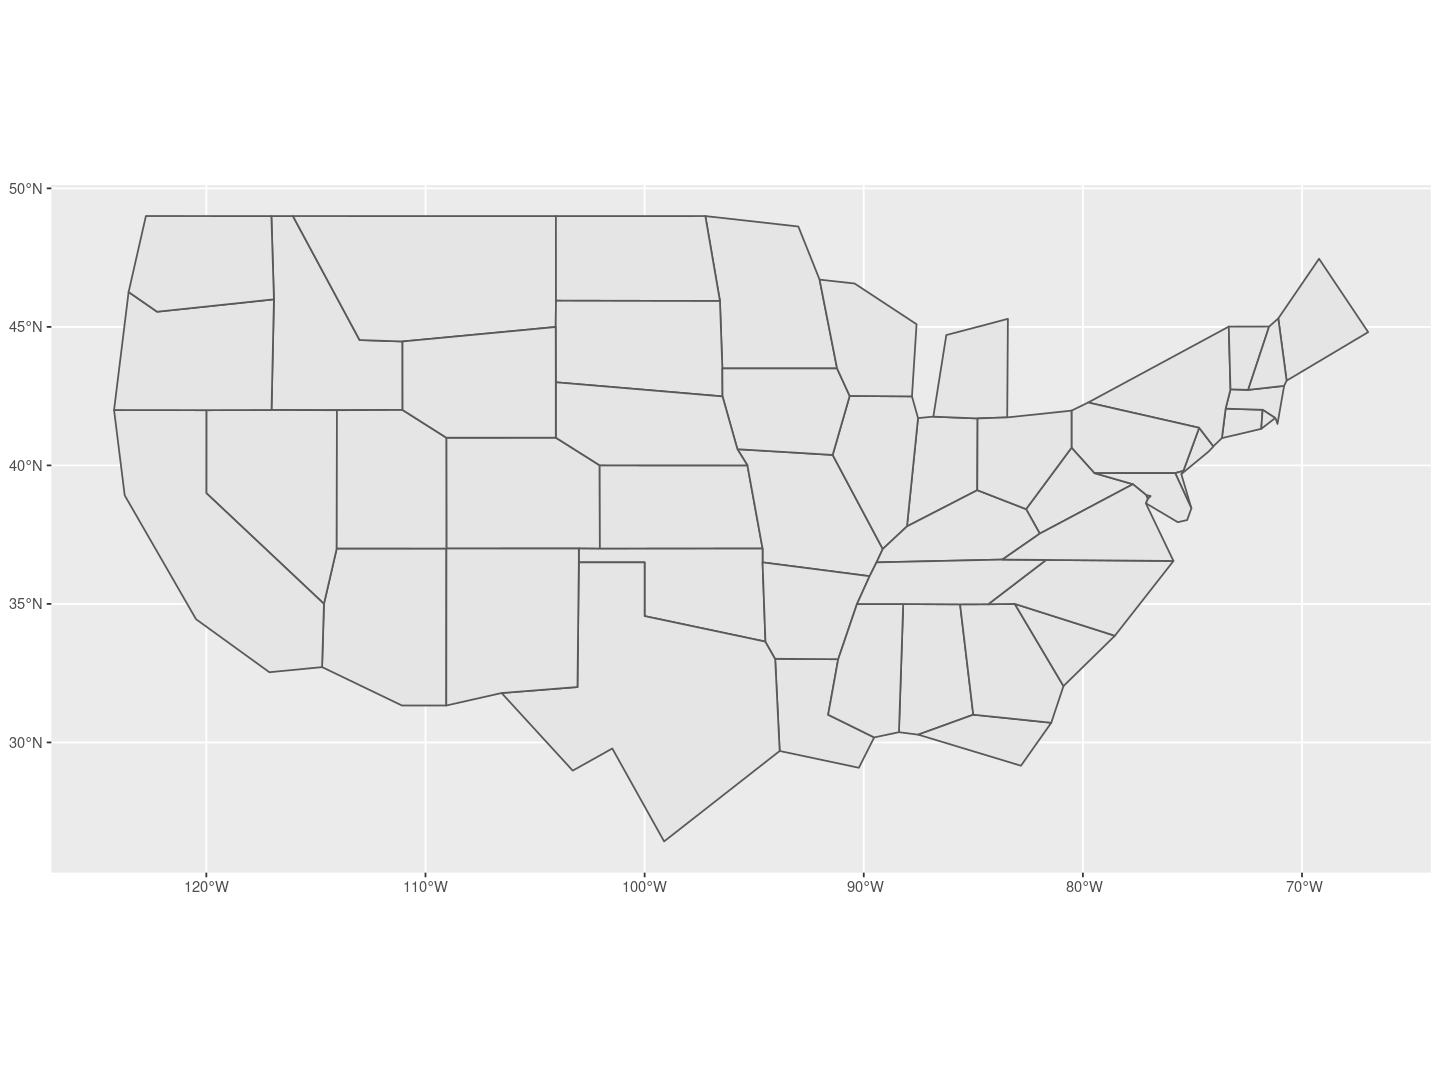

In [20]:
library(rmapshaper)
us_states_wu %>%
    ms_simplify(keep=0.01, keep_shapes=T) %>%
    ggplot() +
    geom_sf()


## Centroids

The *centroid* of an area is its middle point. There are multiple ways to define what "middle" means hear. In the simplest case, it is just the center of gravity.

`st_centroid` computes the centroids of geometries.

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”


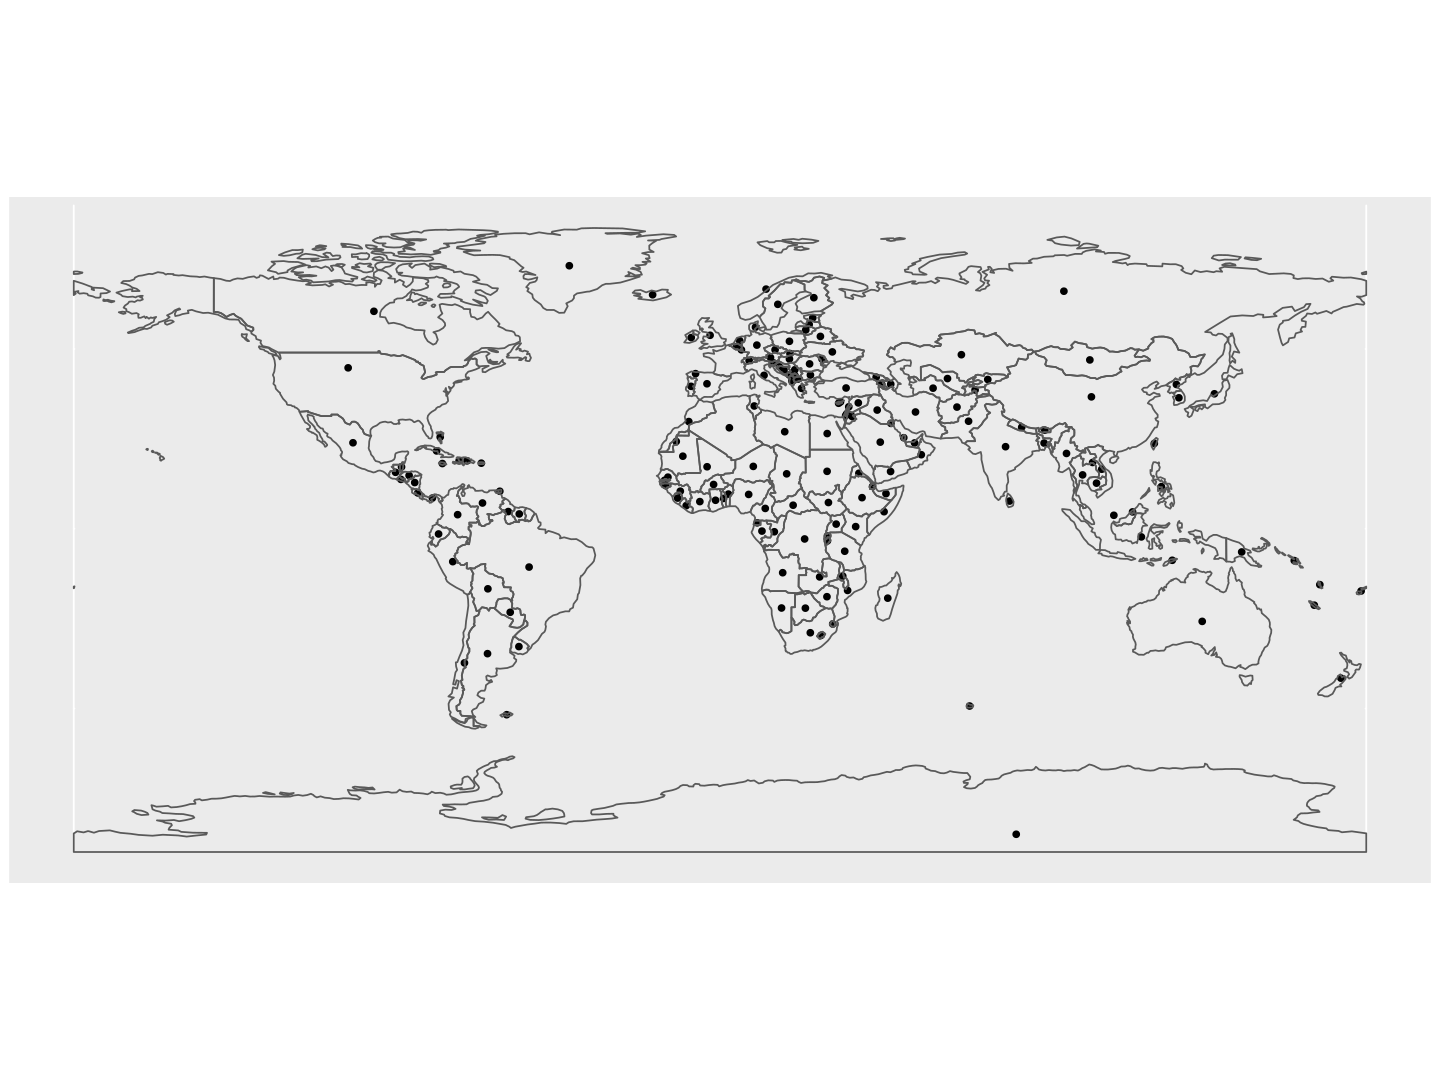

In [22]:
world %>%
    st_centroid() %>%
    ggplot() +
    geom_sf() +
    geom_sf(data=world, alpha=0)

The operation can also be applied to linestrings.

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”


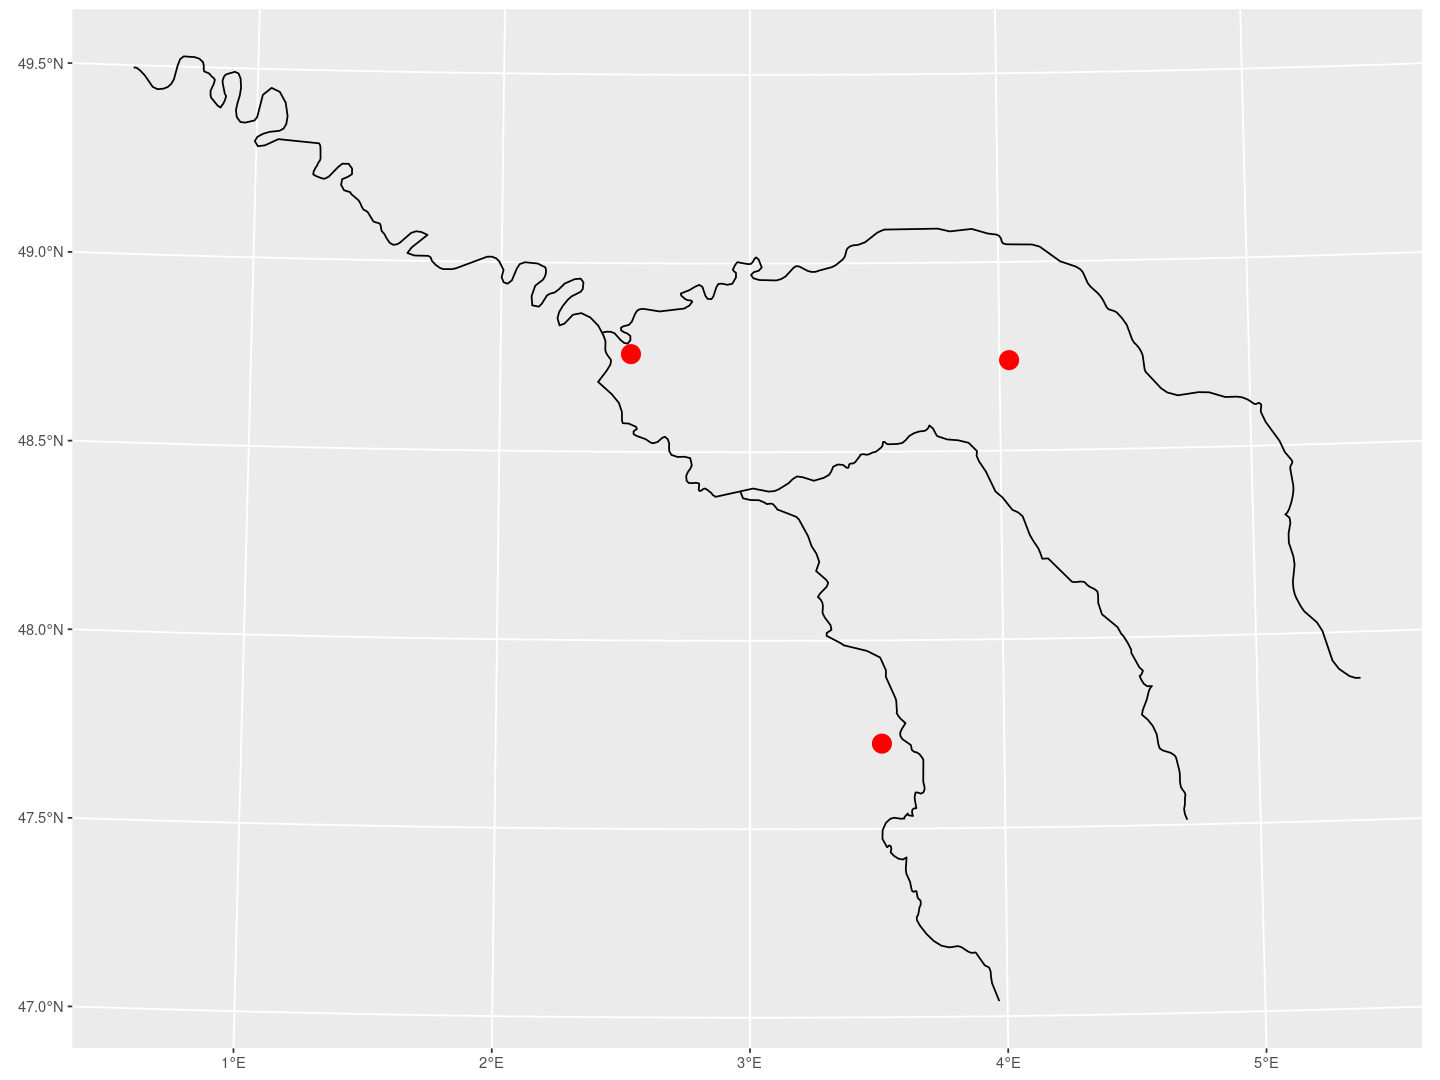

In [23]:
seine %>%
    st_centroid() %>%
    ggplot() +
    geom_sf(col="red", size=5) +
    geom_sf(data=seine)

Here you see that the centroid of an object need not be included in it. We can enforce this with `st_point_on_surface`. 

This is also useful for multipolygons with several components, or concavely shaped polygons.

Warning message in st_point_on_surface.sf(.):
“st_point_on_surface assumes attributes are constant over geometries of x”


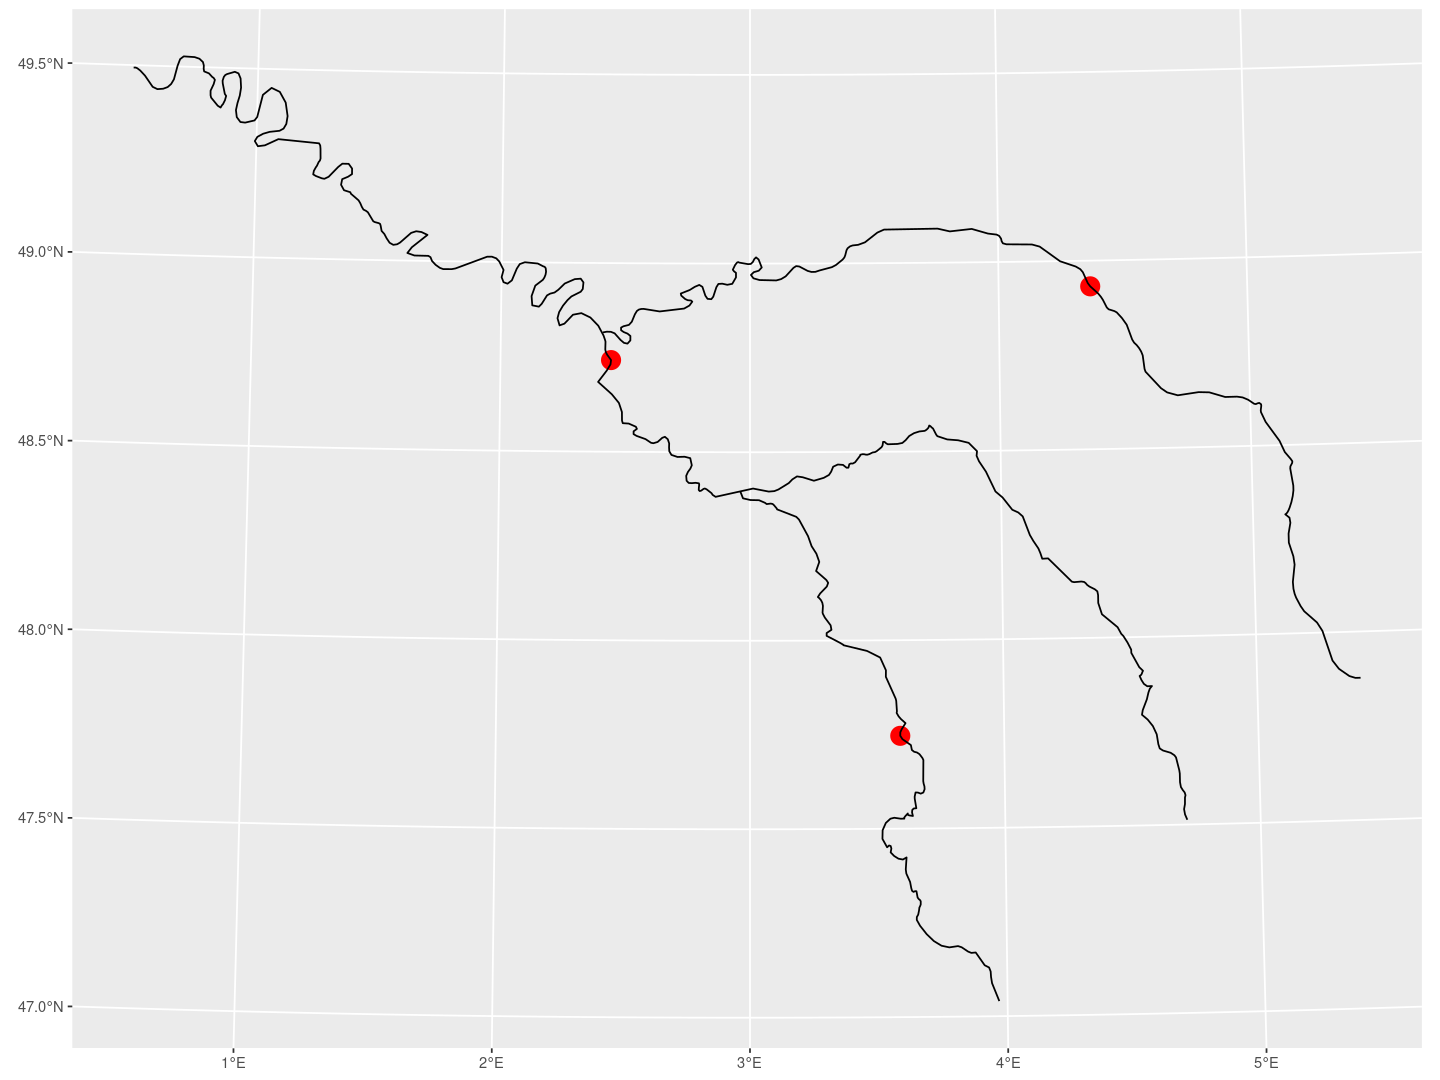

In [24]:
seine %>%
    st_point_on_surface() %>%
    ggplot() +
    geom_sf(col="red", size=5) +
    geom_sf(data=seine)

## Buffers

A spatial *buffer* around a geometry is the area of points within a certain distance of this geometry. It is always a (multi)polygon.

In [25]:
seine

name,geometry
<chr>,<MULTILINESTRING [m]>
Marne,MULTILINESTRING ((879955.3 ...
Seine,MULTILINESTRING ((828893.6 ...
Yonne,MULTILINESTRING ((773482.1 ...


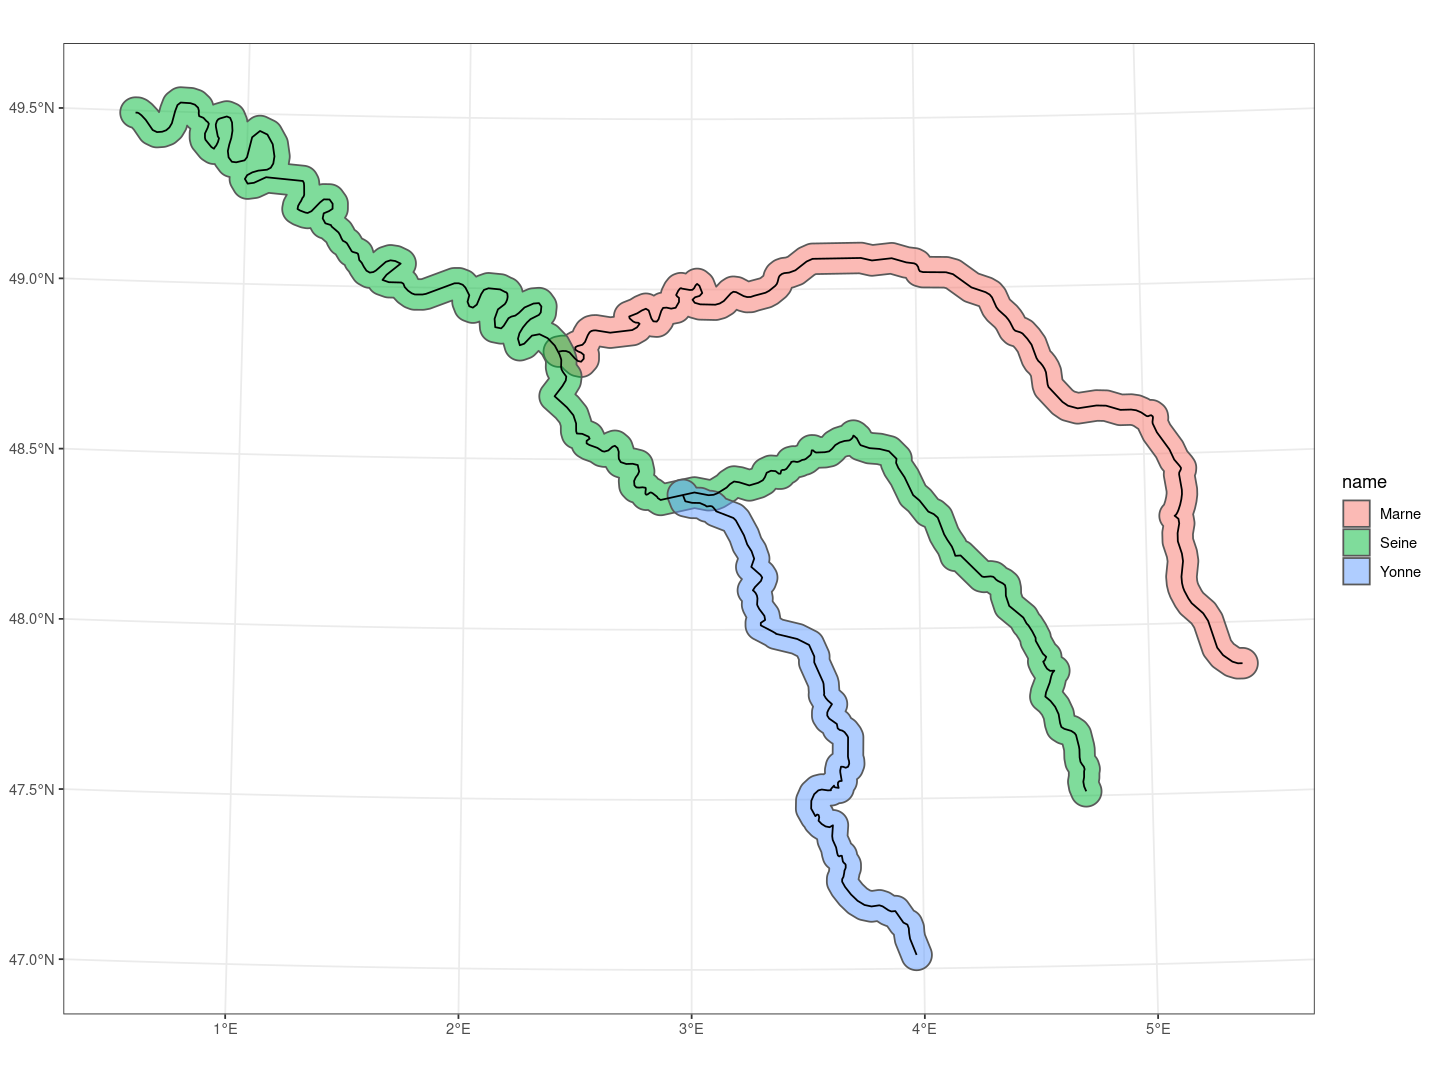

In [26]:
seine %>%
    st_buffer(dist = 5000) %>%
    ggplot() +
    theme_bw() +
    geom_sf(aes(fill=name), alpha=0.5) +
    geom_sf(data=seine)

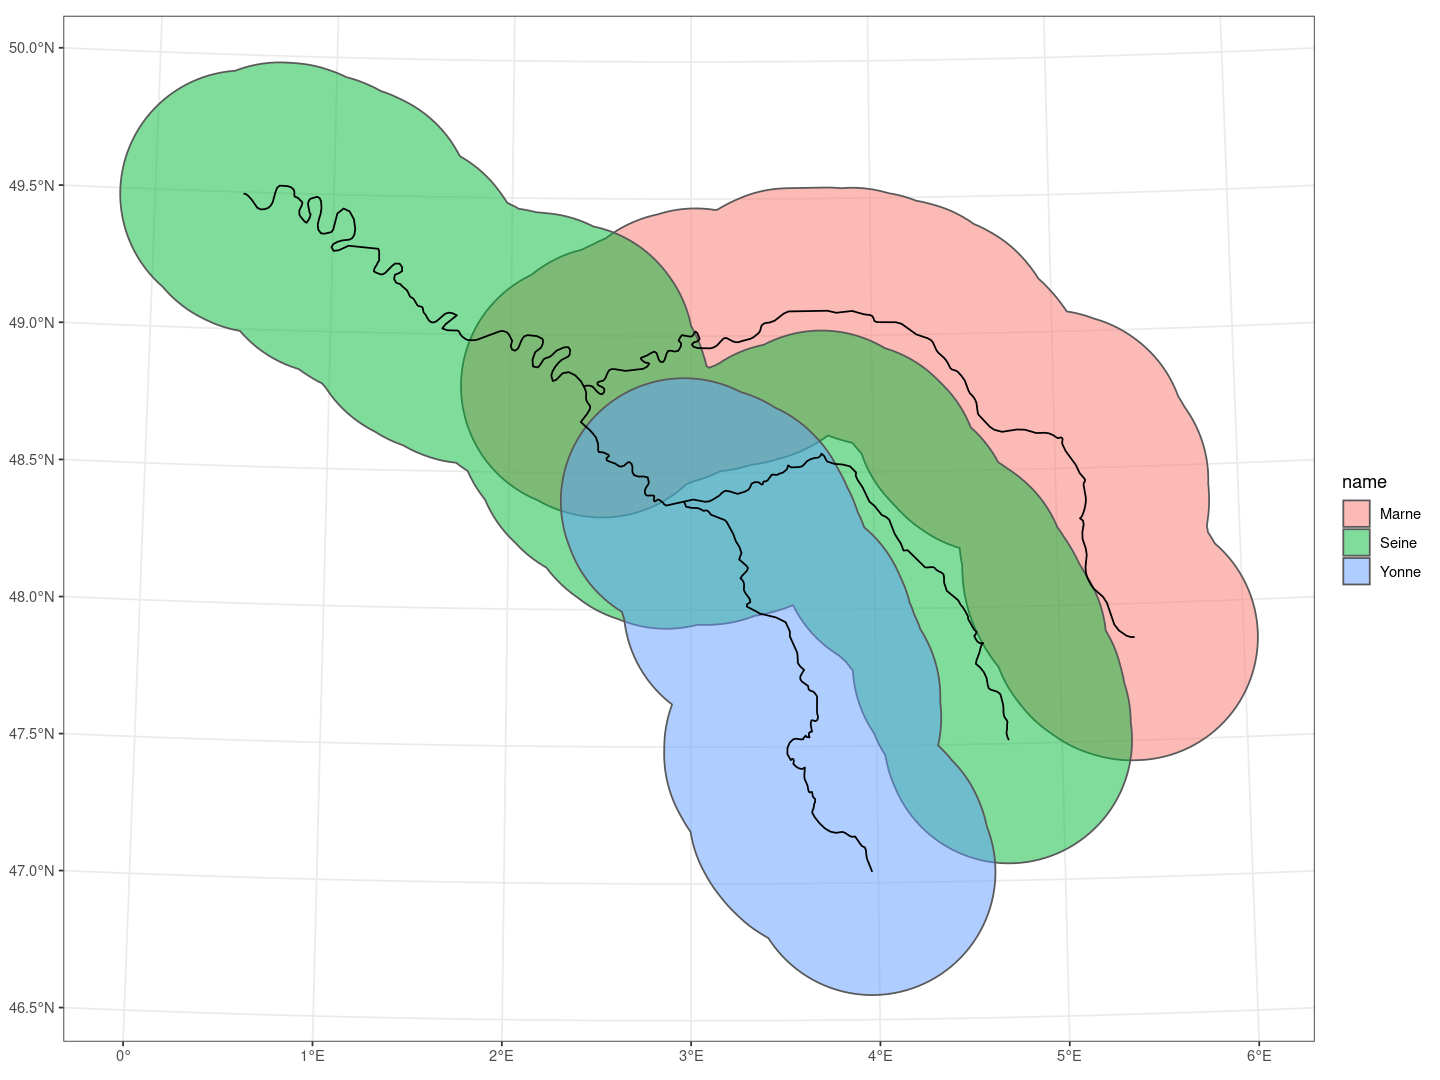

In [27]:
seine %>%
    st_buffer(dist = 50000) %>%
    ggplot() +
    theme_bw() +
    geom_sf(aes(fill=name), alpha=0.5) +
    geom_sf(data=seine)

## Affine transformations

These are all geometric transformations that preserve straight lines and parallels. They are applicable to geometries and geometry columns. The implementation in `sf` is so that we can apply the same operations we would apply to vectors.


### Translation

Simply add the translation vector to the geometries.

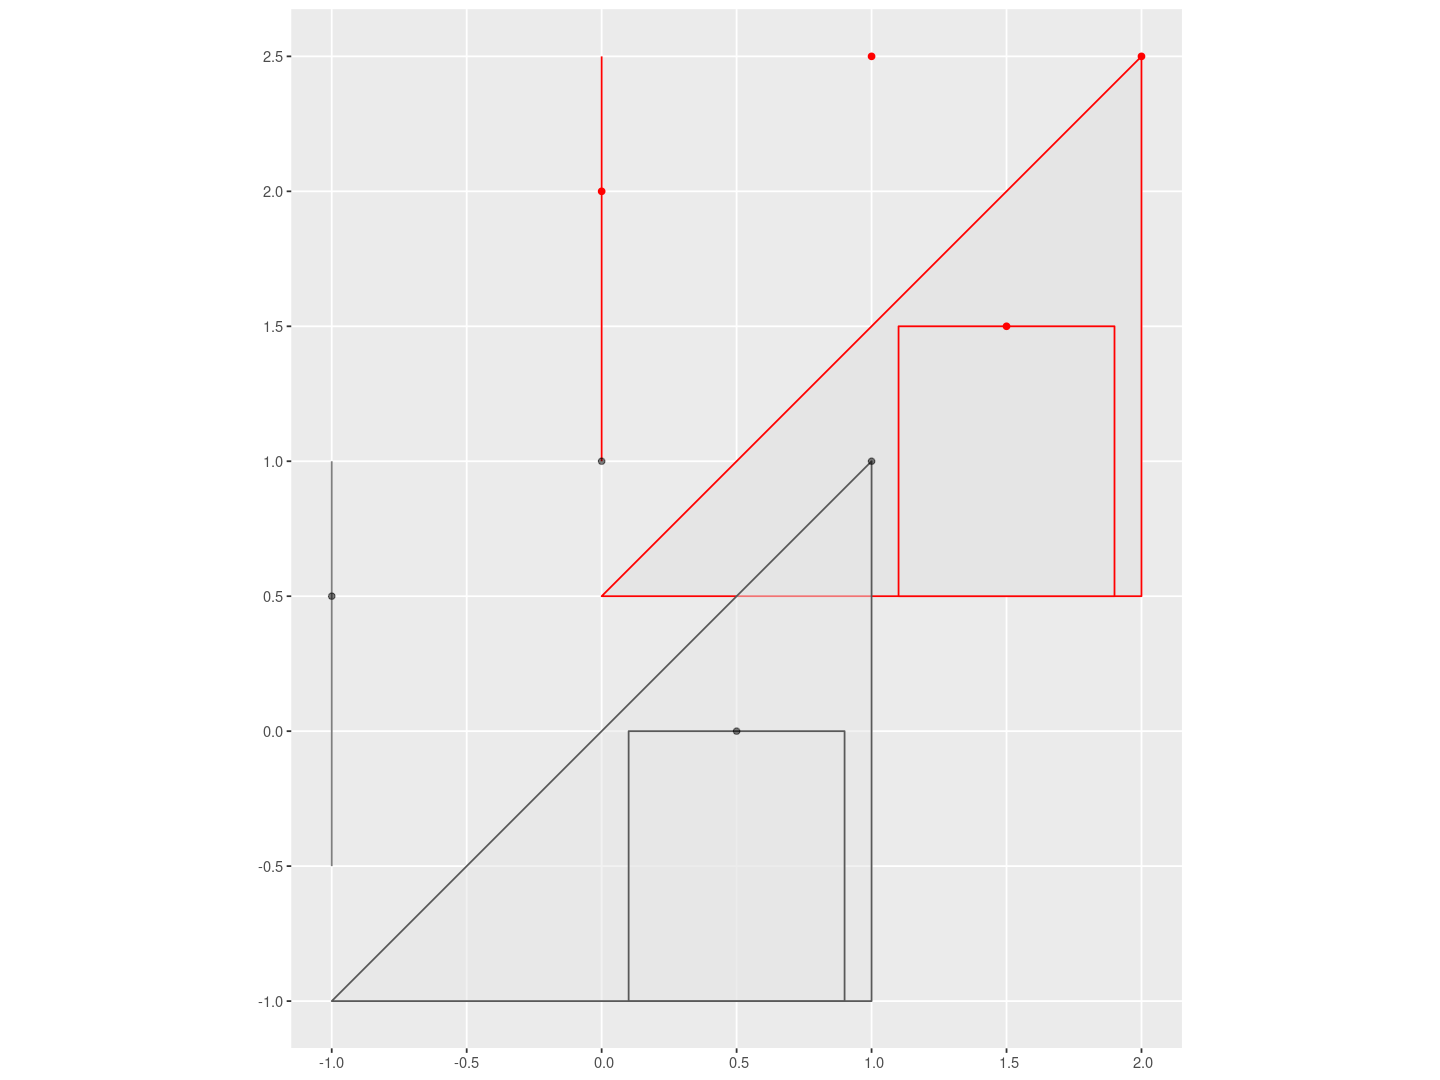

In [28]:
(exampleGeometries %>%
    st_geometry() + c(1, 1.5)) %>% 
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)



### Mirroring

Multiply the geometries with the matrix
$$
\begin{pmatrix}
-1 & 0\\
0 & 1
\end{pmatrix}
$$

for mirroring along the $x$-axis, and 

$$
\begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
$$

along the $y$-axis.


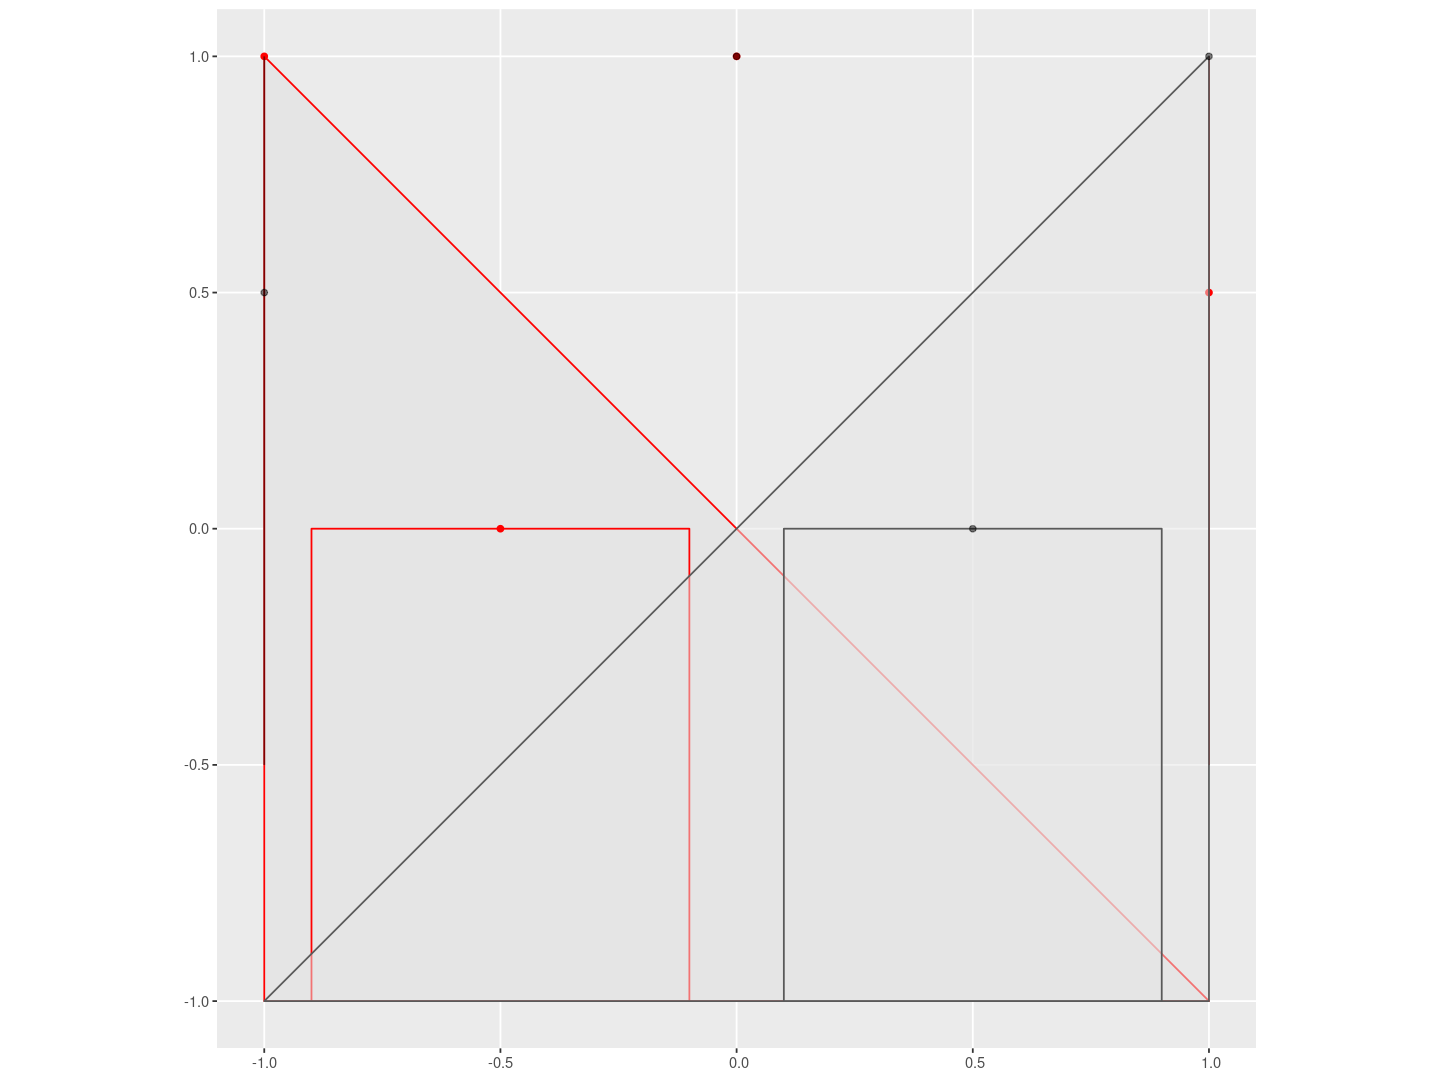

In [29]:

(exampleGeometries %>%
    st_geometry() * matrix(c(-1, 0, 0, 1), nrow=2)) %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

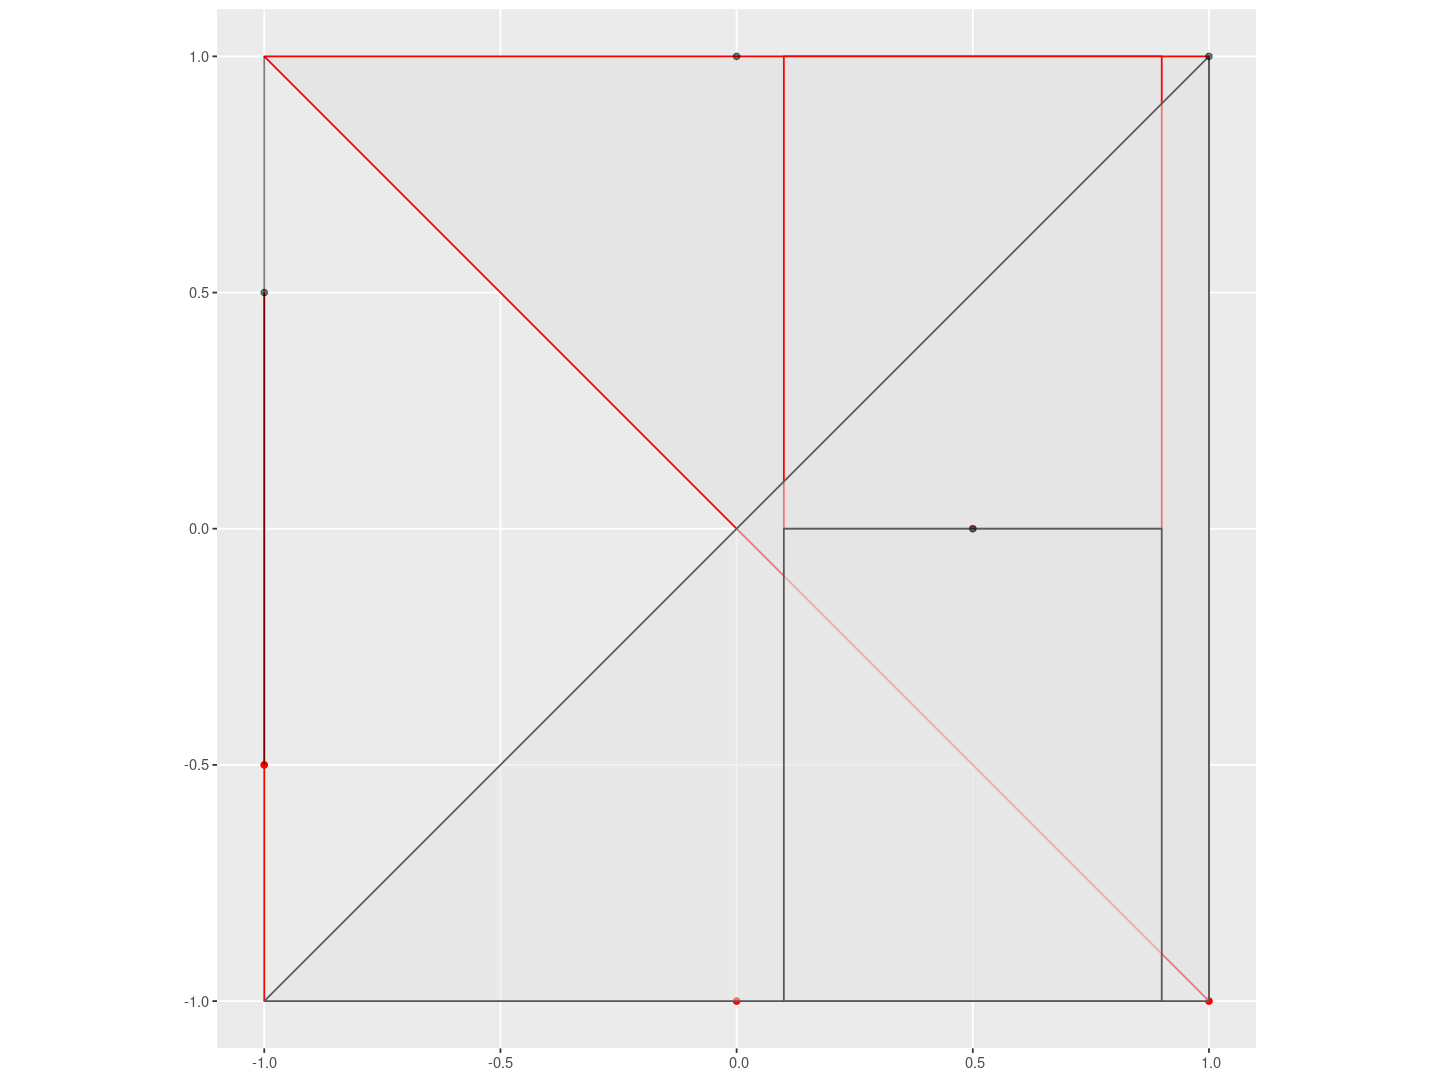

In [30]:
(exampleGeometries %>%
    st_geometry() * matrix(c(1, 0, 0, -1), nrow=2)) %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

### Skewing

Multiply the geometries with the matrix 
$$
\begin{pmatrix}
u \\v
\end{pmatrix}
$$

where $u$ is the image of the vector $\begin{pmatrix}1\\0\end{pmatrix}$, and $v$ the image of $\begin{pmatrix}0\\1\end{pmatrix}$

In [31]:
(skewMatrix <- matrix(
    c(1, 1, 0, 1), nrow=2
))

1,0
1,1


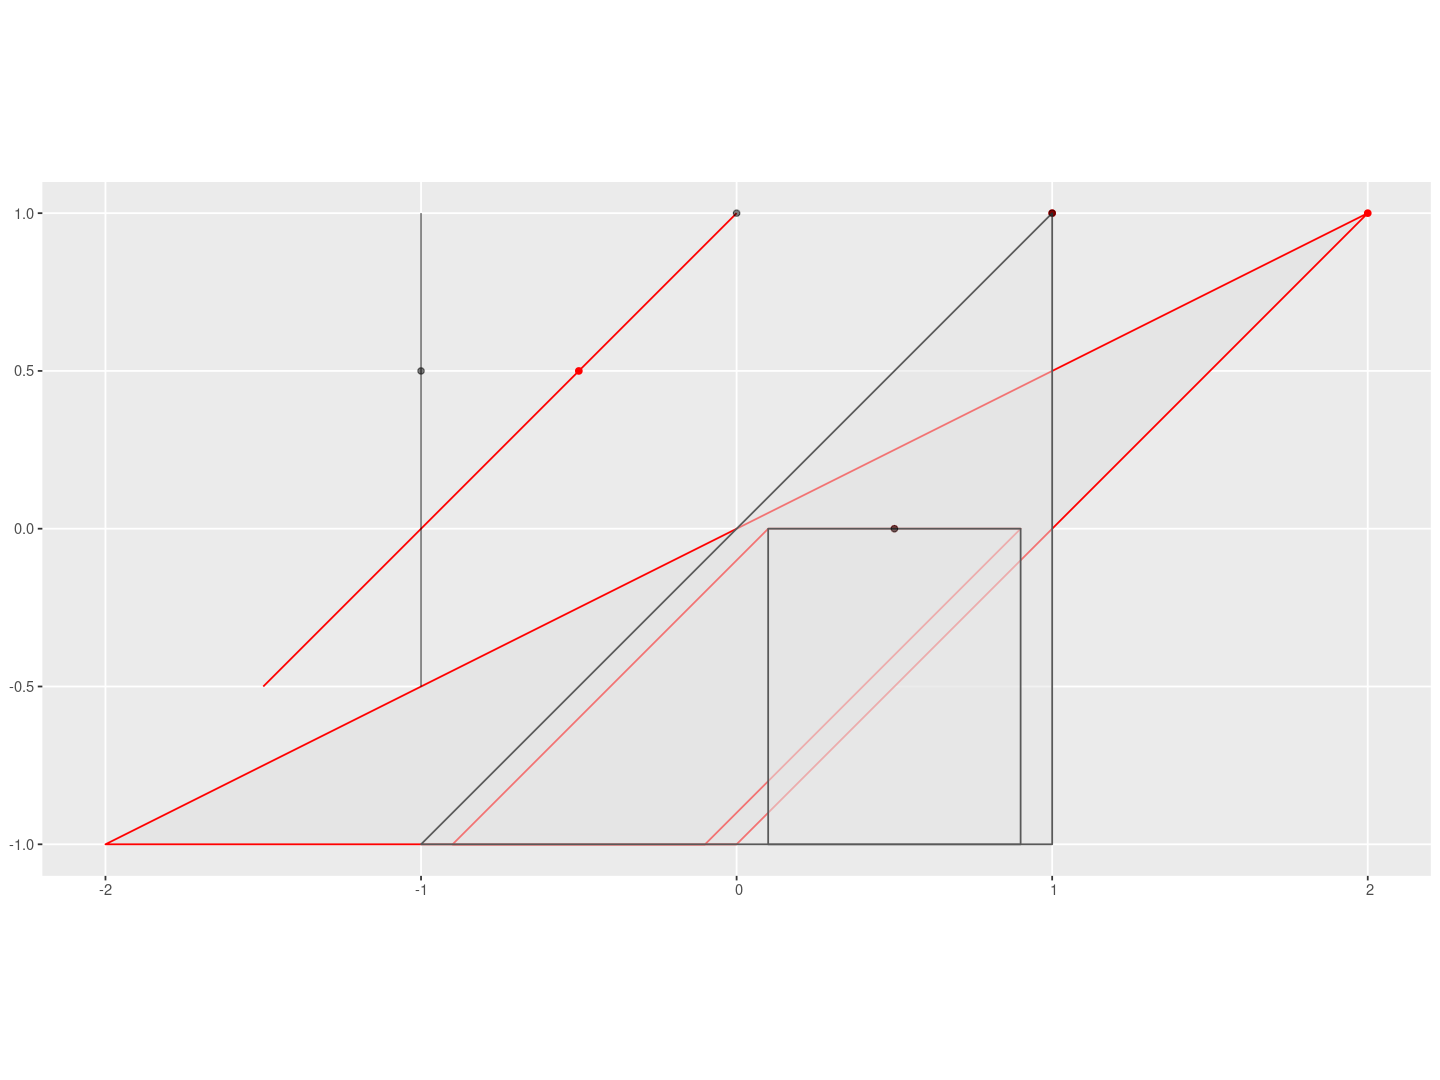

In [32]:
(exampleGeometries %>%
    st_geometry() * skewMatrix)  %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

### Rotation

works as skewing, via matrix multiplication.

#### Matrix for clock-wise rotation by 45°:

In [33]:
(rotationMatrix <- matrix(
    c(sqrt(.5), sqrt(.5), -sqrt(.5), sqrt(.5)),
    nrow=2
))

0.7071068,-0.7071068
0.7071068,0.7071068


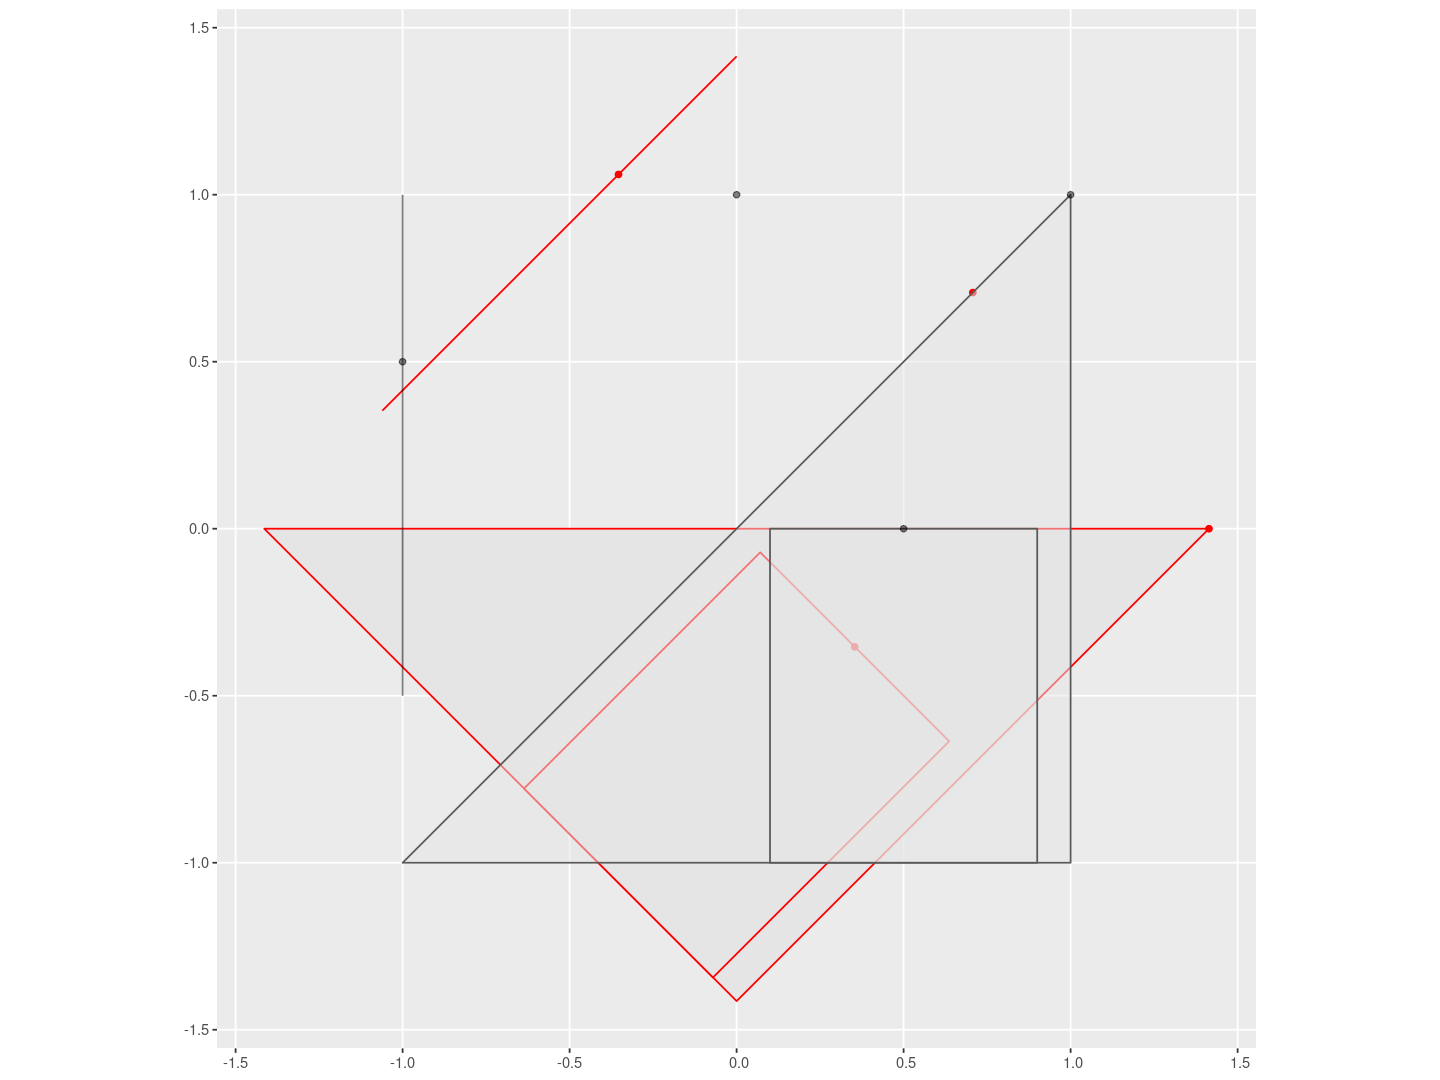

In [34]:
(exampleGeometries %>%
    st_geometry() * rotationMatrix)  %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

### Scaling

works by the same principle. In a scaling matrix, only the diagonal entries are non-zero. The upper left corner contains the horizontal scale factor, and the lower right corner contains the vertical scale factor.

In [35]:
(scaleMatrix <- matrix(
    c(2, 0, 0, 0.5),
    nrow=2
))

2,0.0
0,0.5


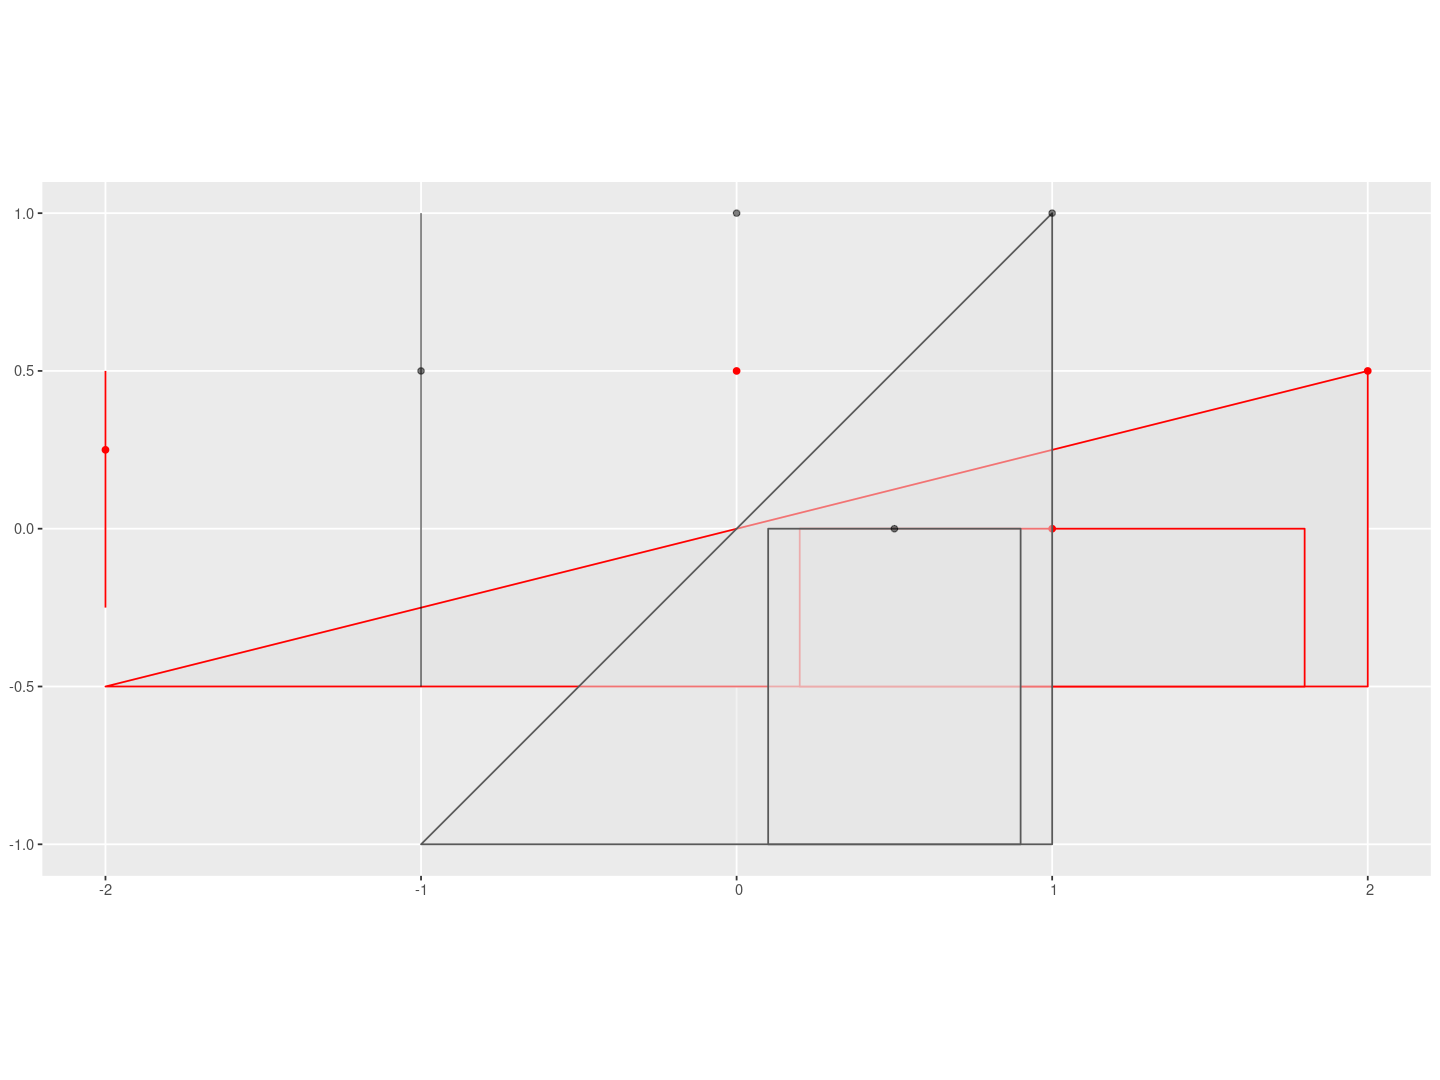

In [36]:
(exampleGeometries %>%
    st_geometry() * scaleMatrix)  %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

## Spatial set-theoretic operations.

We can apply the standard set-theoretic operations to geometries

In [37]:
p1 = st_point(c(-1, 0))
p2 = st_point(c(1, 0))

circles <- st_sfc(p1, p2) %>%
    st_buffer(dist = 1.5) %>%
    st_sf()

circles[["name"]] <- c("A", "B")

In [38]:
circles

,geometry,name
,<POLYGON>,<chr>
1,"POLYGON ((0.5 0, 0.4979443 ...",A
2,"POLYGON ((2.5 0, 2.497944 -...",B


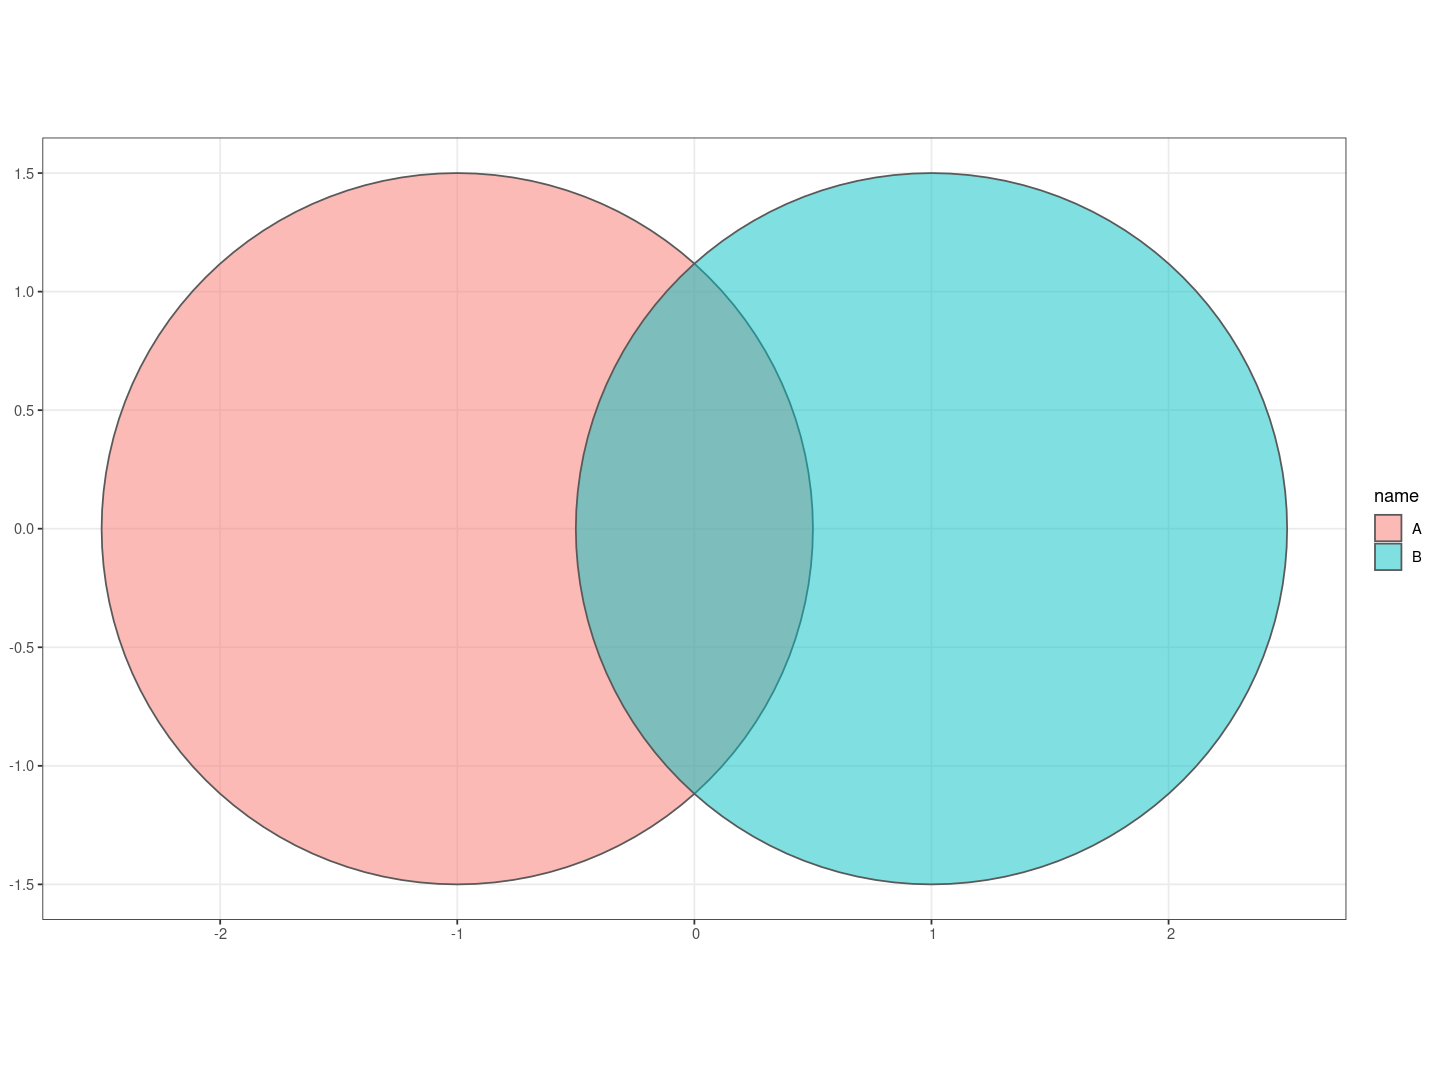

In [39]:
circles %>%
    ggplot() +
    theme_bw() +
    geom_sf(alpha = .5, aes(fill=name))

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


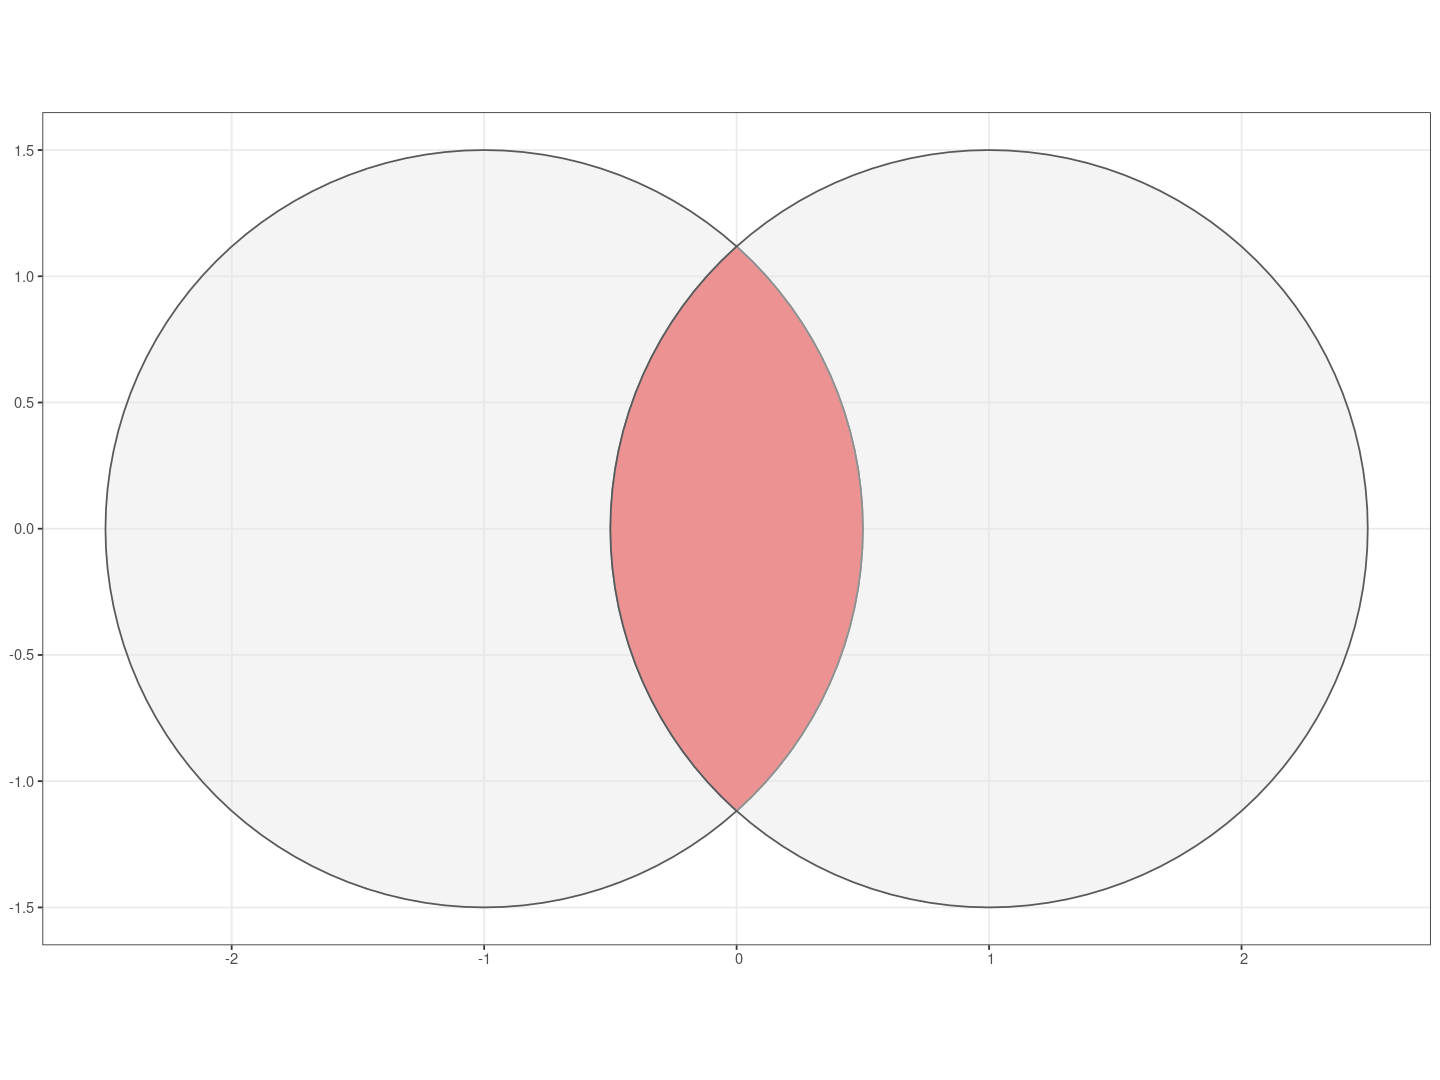

In [40]:
circles[1,] %>%
    st_intersection(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') +
    geom_sf(data=circles, alpha=.4)


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


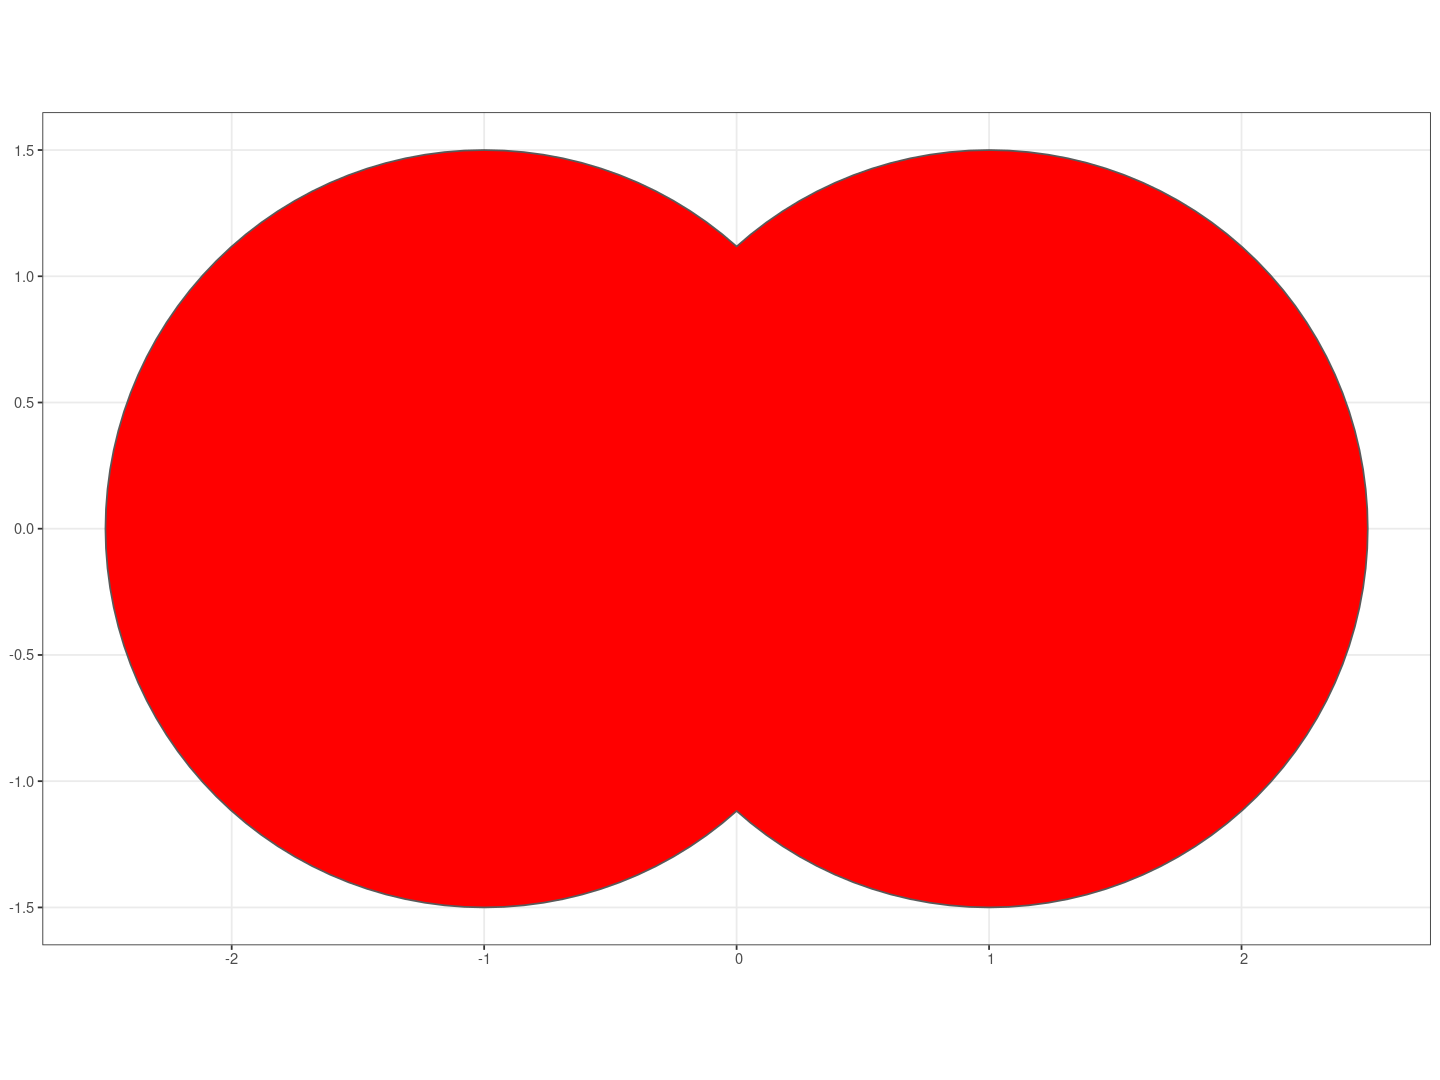

In [41]:
circles[1,] %>%
    st_union(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') 


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


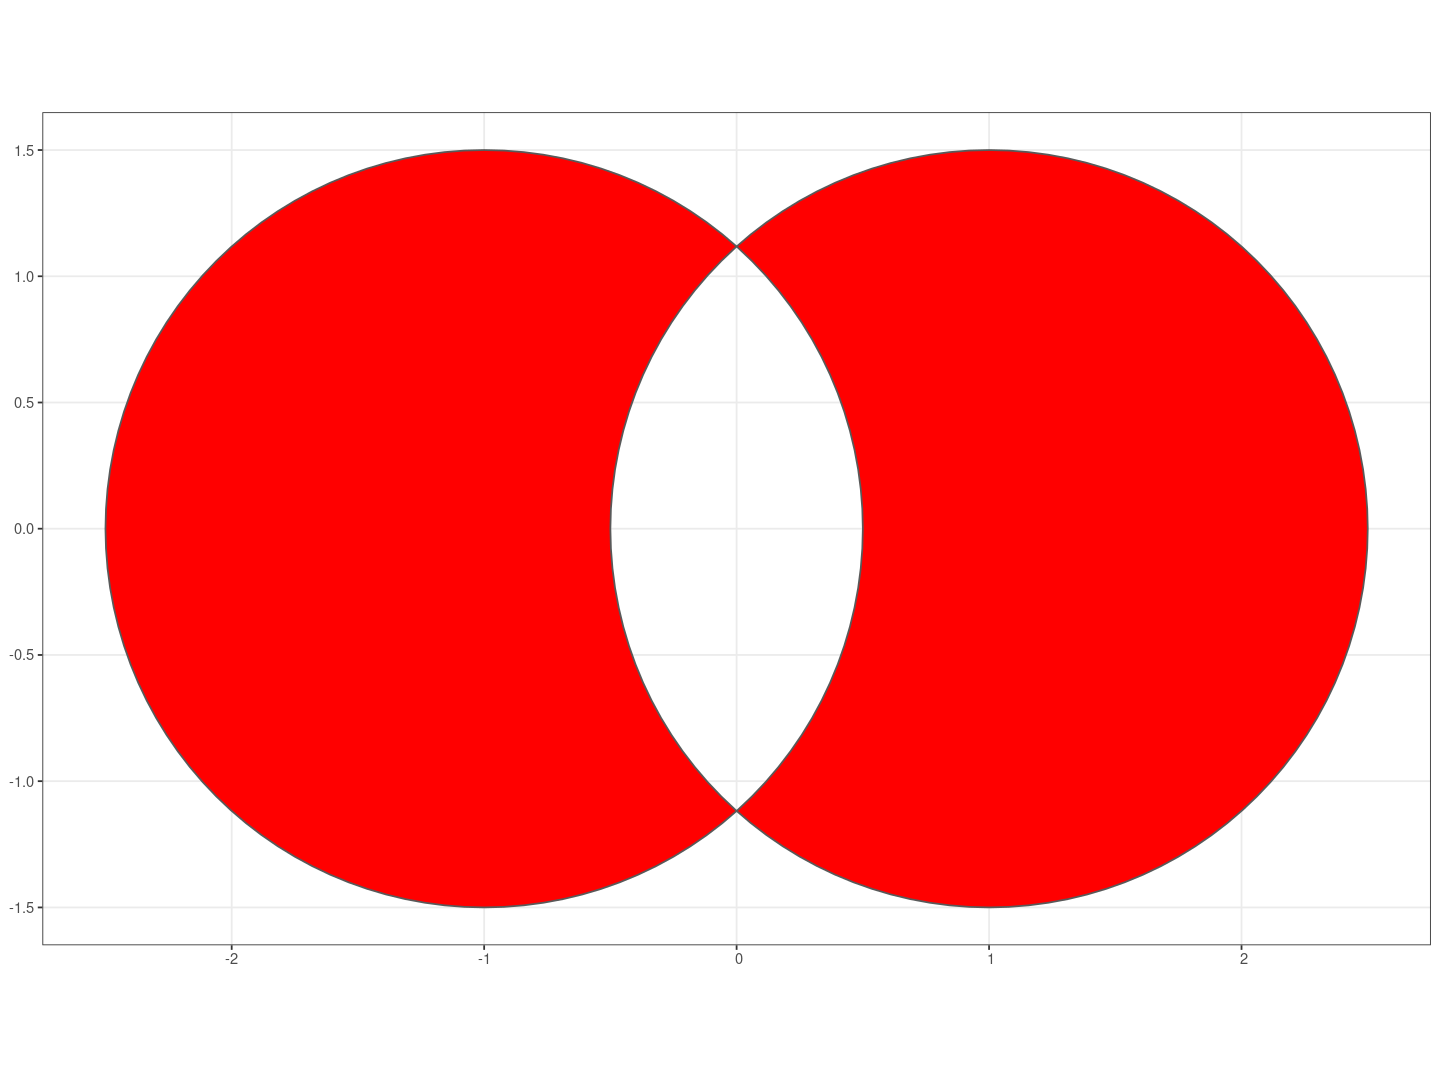

In [42]:
circles[1,] %>%
    st_sym_difference(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') 


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


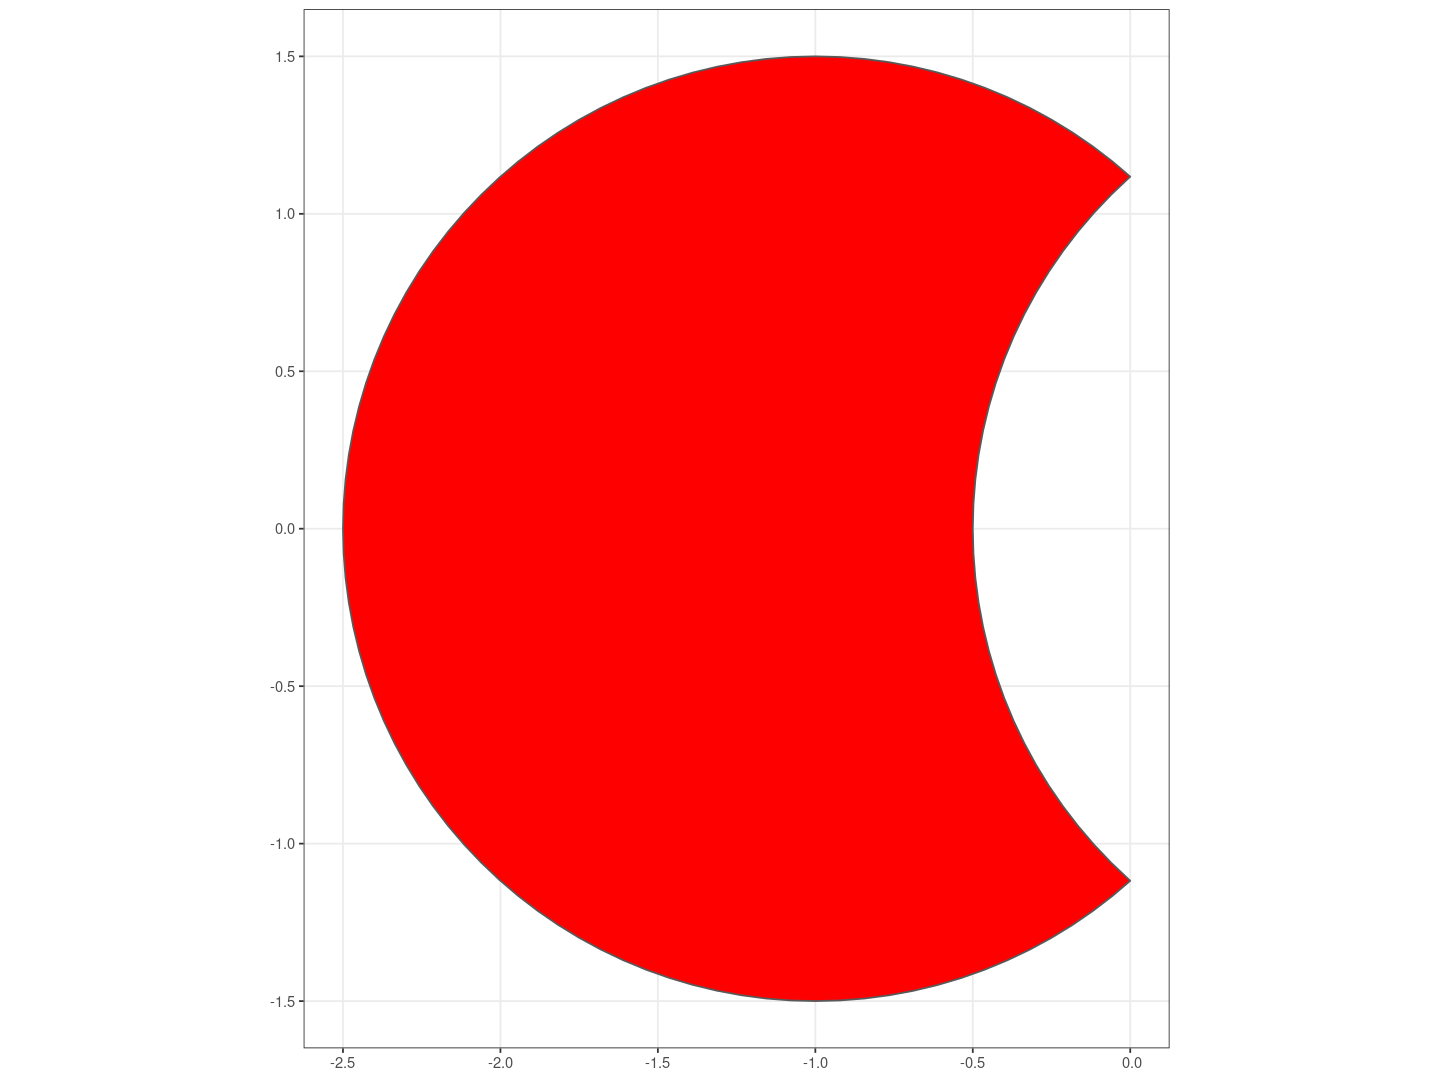

In [43]:
circles[1,] %>%
    st_difference(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') 

## Spatial subsetting

Spatial subsetting is the operation of selection a subset of observations from some dataset on the basis of its *spatial* relation to some object (or collection of objects). 

It can be seen as an extension of the `filter` operation from `tidyverse` with spatial filter criteria.

**Example: High points in New Zealand**

Consider the following two datasets from `spData`:

In [44]:
nz %>%
    slice_sample(n=10)

Name,Island,Land_area,Population,Median_income,Sex_ratio,geom
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<MULTIPOLYGON [m]>
Marlborough,South,10457.7455,46200,27900,0.9577922,MULTIPOLYGON (((1686902 535...
Northland,North,12500.5611,175500,23400,0.9424532,MULTIPOLYGON (((1745493 600...
Auckland,North,4941.5726,1657200,29600,0.9442858,MULTIPOLYGON (((1803822 590...
Wellington,North,8048.5528,513900,32700,0.9335524,MULTIPOLYGON (((1881590 548...
Nelson,South,422.1952,51400,27200,0.9259674,MULTIPOLYGON (((1624866 541...
Tasman,South,9615.9760,51100,25700,0.9718981,MULTIPOLYGON (((1616643 542...
Gisborne,North,8385.8266,48500,24400,0.9349734,MULTIPOLYGON (((2024489 567...
Taranaki,North,7254.4804,118000,29100,0.9569363,MULTIPOLYGON (((1740438 571...
Bay of Plenty,North,12071.1447,299900,26200,0.9280391,MULTIPOLYGON (((2049387 583...


In [45]:
nz_height %>%
    slice_sample(n=10)

t50_fid,elevation,geometry
<int>,<int>,<POINT [m]>
2364026,2891,POINT (1374899 5176232)
2364010,2950,POINT (1381328 5171486)
2363997,3070,POINT (1373796 5174144)
2372186,3151,POINT (1361593 5159139)
2364027,2899,POINT (1374895 5176458)
2372232,2925,POINT (1369510 5166149)
2364060,2807,POINT (1380511 5179463)
2364164,2810,POINT (1385568 5180142)
2364059,2909,POINT (1380093 5179167)


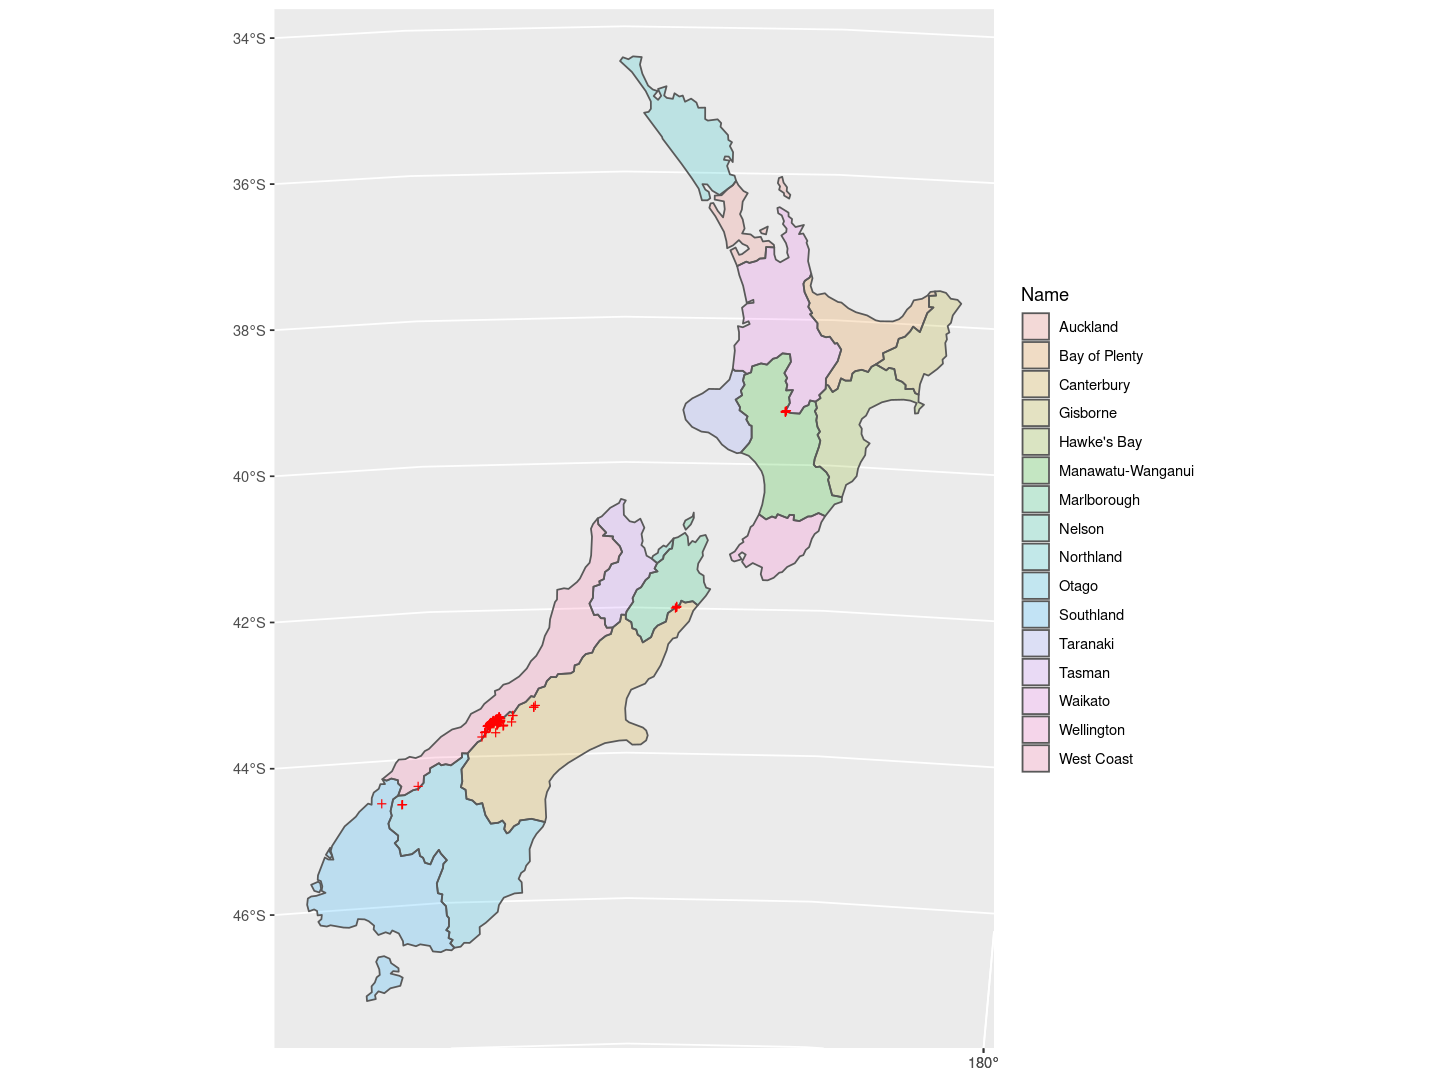

In [46]:
nz %>%
    ggplot() +
    geom_sf(aes(fill=Name), alpha=0.2) +
    geom_sf(data=nz_height, col='red', pch=3)

We want to find all high elevation points with the region *Canterbury*.

In [47]:
canterbury <- nz %>%
    filter(Name == "Canterbury")
canterbury

,Name,Island,Land_area,Population,Median_income,Sex_ratio,geom
,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<MULTIPOLYGON [m]>
1,Canterbury,South,44504.5,612000,30100,0.9753265,MULTIPOLYGON (((1686902 535...


In [48]:
st_intersects(nz_height, canterbury, sparse=F)

FALSE
FALSE
FALSE
FALSE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


In [49]:
canterbury_height <- nz_height %>%
    filter(st_intersects(x=., y=canterbury, sparse=F))

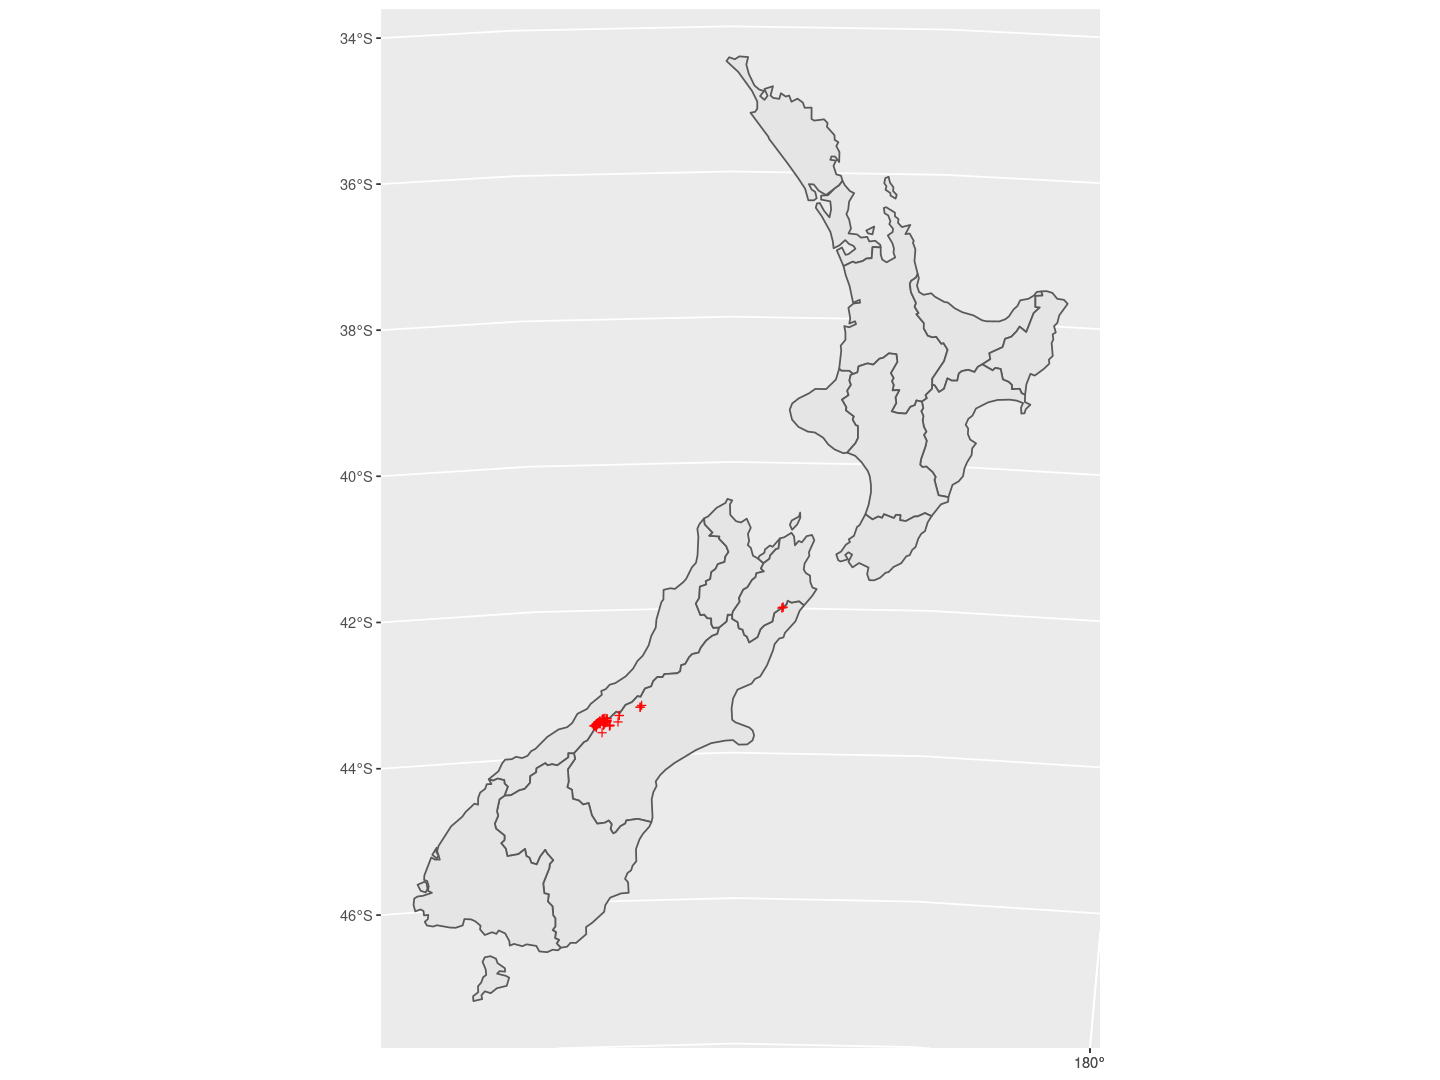

In [50]:
nz %>% 
    ggplot() +
    geom_sf() +
    geom_sf(data=canterbury_height, col='red', pch=3)

The same method can be applied with other geometric relations as well.

## Spatial joining

In a regular join operation, two observations from the two tibbles involved are merged if they have the same value for the `by` column.

In *spatial joining*, we combine observations from `sf` objects based on their geometries. It has to be specified which geometric relation holds between them. The default is `st_intersects`.

### Example: Random points on a world map

In [51]:
# bounding box of 'world'

(bb_world = st_bbox(world))

      xmin       ymin       xmax       ymax 
-180.00000  -89.90000  179.99999   83.64513 

In [52]:
random_df = tibble(
  x = runif(n = 10, min = bb_world[1], max = bb_world[3]),
  y = runif(n = 10, min = bb_world[2], max = bb_world[4])
)
random_df

x,y
<dbl>,<dbl>
-23.56341,-58.27482
-158.93572,-27.11813
-103.91971,24.37497
165.46457,-38.13098
-160.91885,-68.46323
61.98197,29.46574
157.22074,-21.63406
139.75247,-20.13273
82.66760,23.15482


In [53]:
random_points = random_df %>% 
  st_as_sf(coords = c("x", "y")) %>% # set coordinates
  st_set_crs(4326) # set geographic CRS

random_points
 

,geometry
,<POINT [°]>
1,POINT (-23.56341 -58.27482)
2,POINT (-158.9357 -27.11813)
3,POINT (-103.9197 24.37497)
4,POINT (165.4646 -38.13098)
5,POINT (-160.9189 -68.46323)
6,POINT (61.98197 29.46574)
7,POINT (157.2207 -21.63406)
8,POINT (139.7525 -20.13273)
9,POINT (82.6676 23.15482)


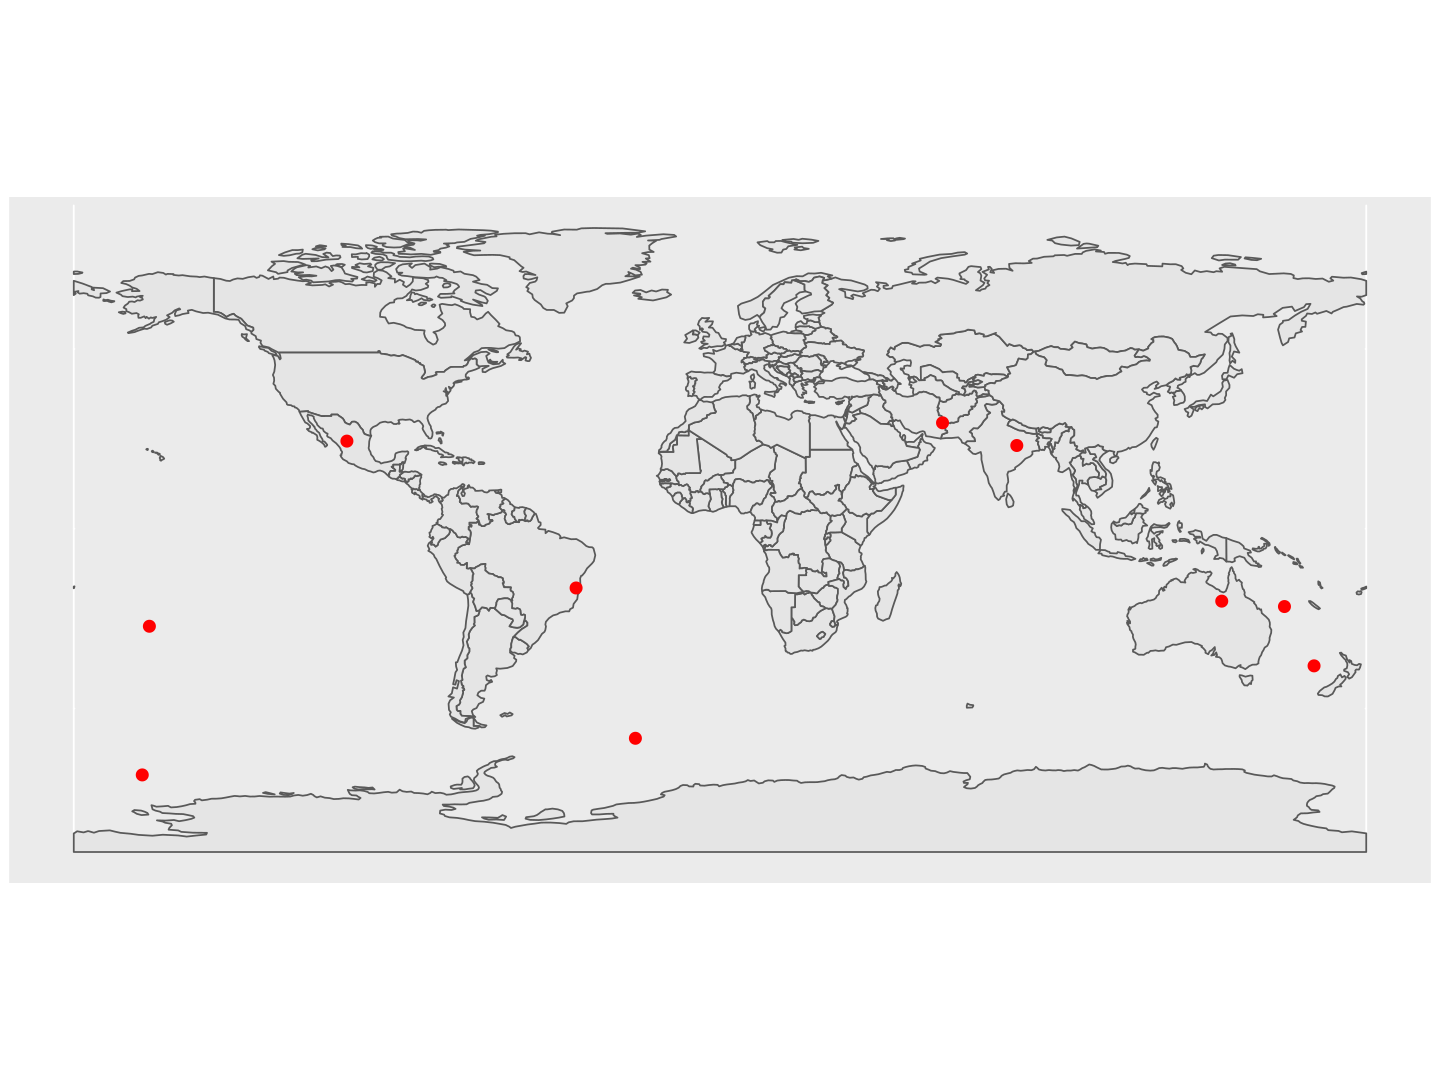

In [54]:
world %>% 
    ggplot() +
    geom_sf() +
    geom_sf(data=random_points, color='red', size=3)


In [55]:
random_points %>%
    st_join(world) 


,geometry,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap
,<POINT [°]>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,POINT (-23.56341 -58.27482),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,POINT (-158.9357 -27.11813),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,POINT (-103.9197 24.37497),MX,Mexico,North America,Americas,Central America,Sovereign country,1969480,124221600,76.753,16622.597
4,POINT (165.4646 -38.13098),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,POINT (-160.9189 -68.46323),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,POINT (61.98197 29.46574),PK,Pakistan,Asia,Asia,Southern Asia,Sovereign country,874120,185546257,66.139,4576.227
7,POINT (157.2207 -21.63406),NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,POINT (139.7525 -20.13273),AU,Australia,Oceania,Oceania,Australia and New Zealand,Country,7687614,23504138,82.300,43547.197
9,POINT (82.6676 23.15482),IN,India,Asia,Asia,Southern Asia,Sovereign country,3142892,1293859294,68.021,5385.142


In [56]:
countries_with_point <- random_points %>%
    st_join(world, left=F) %>%
    pull(iso_a2)

countries_with_point

[1] "MX" "PK" "AU" "IN" "BR"

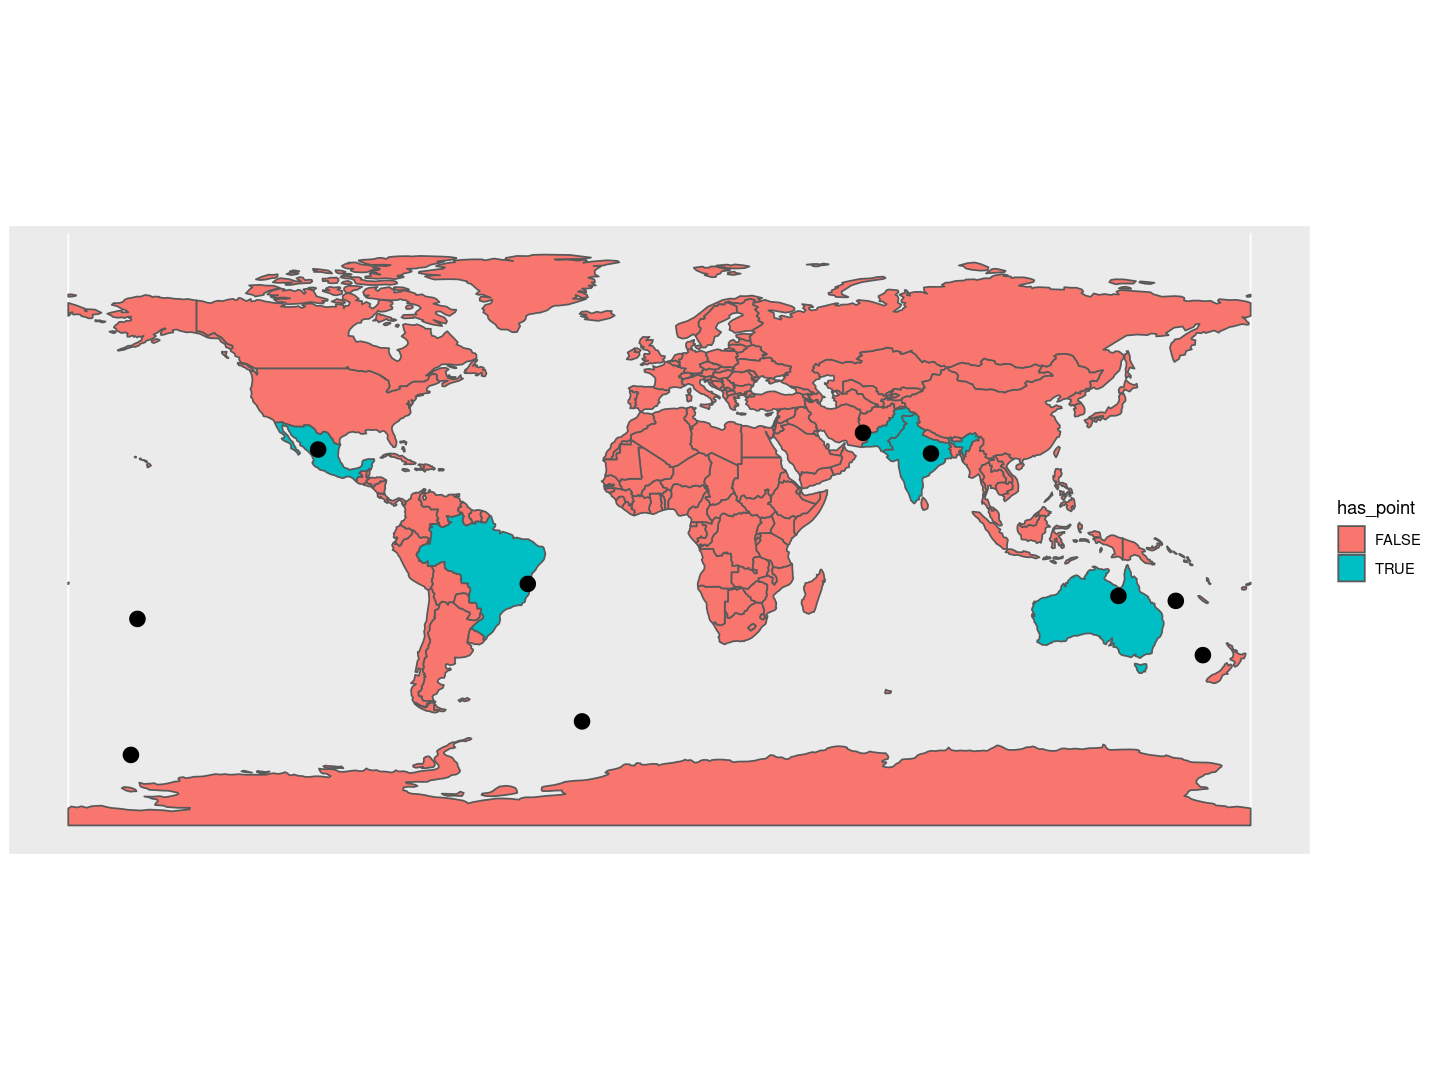

In [57]:
world %>% 
    mutate(has_point = iso_a2 %in% countries_with_point) %>%
    ggplot() +
    geom_sf(aes(fill=has_point)) +
    geom_sf(data=random_points, size=4)


## Spatial joining with non-overlapping data

Sometimes one wants to spatially join data where the spatial information is not identical but overlapping (e.g., due to measurement errors or different precision levels).

Consider the following two datasets from `spData`:

In [58]:
cycle_hire %>% 
    slice_sample(n=10)

id,name,area,nbikes,nempty,geometry
<int>,<fct>,<fct>,<int>,<int>,<POINT [°]>
201,Dorset Square,Marylebone,15,0,POINT (-0.1611134 51.5226)
166,Seville Street,Knightsbridge,0,26,POINT (-0.1592371 51.50186)
296,Knaresborough Place,Earl's Court,13,5,POINT (-0.1906033 51.49363)
372,Sardinia Street,Holborn,10,14,POINT (-0.117863 51.51521)
480,Flamborough Street,Limehouse,24,0,POINT (-0.0389866 51.51287)
175,Appold Street,Liverpool Street,0,24,POINT (-0.0811189 51.52174)
270,Kennington Lane Rail Bridge,Vauxhall,21,10,POINT (-0.1224924 51.48634)
9,New Globe Walk,Bankside,3,16,POINT (-0.09644075 51.50739)
93,Cloudesley Road,Angel,19,18,POINT (-0.1090254 51.53441)


In [59]:
cycle_hire_osm %>%
    slice_sample(n=10)

osm_id,name,capacity,cyclestreets_id,description,geometry
<fct>,<fct>,<dbl>,<fct>,<fct>,<POINT [°]>
2362220934,New North Road,NA,NA,NA,POINT (-0.0859581 51.53112)
1176868173,NA,20,NA,NA,POINT (-0.2007307 51.50235)
1176759014,"Mayfair, Clifford Street",16,NA,NA,POINT (-0.1421763 51.5107)
826142422,"The Borough, Borough High Street",11,NA,NA,POINT (-0.0945159 51.50062)
926239828,"Kennington, Cotton Garden Estate",14,NA,NA,POINT (-0.1062222 51.49075)
851841191,Bedford Way,13,NA,NA,POINT (-0.1284389 51.52369)
1163259562,Millenium Hotel,17,NA,NA,POINT (-0.151218 51.51092)
926239935,"Kennington, Kennington Cross",19,NA,NA,POINT (-0.1114194 51.48895)
2578207985,Grant Road West,NA,NA,NA,POINT (-0.1747123 51.46437)


Check compatibility:

In [60]:
cycle_hire %>%
    st_crs()

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]

In [61]:
cycle_hire_osm %>%
    st_crs()

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]

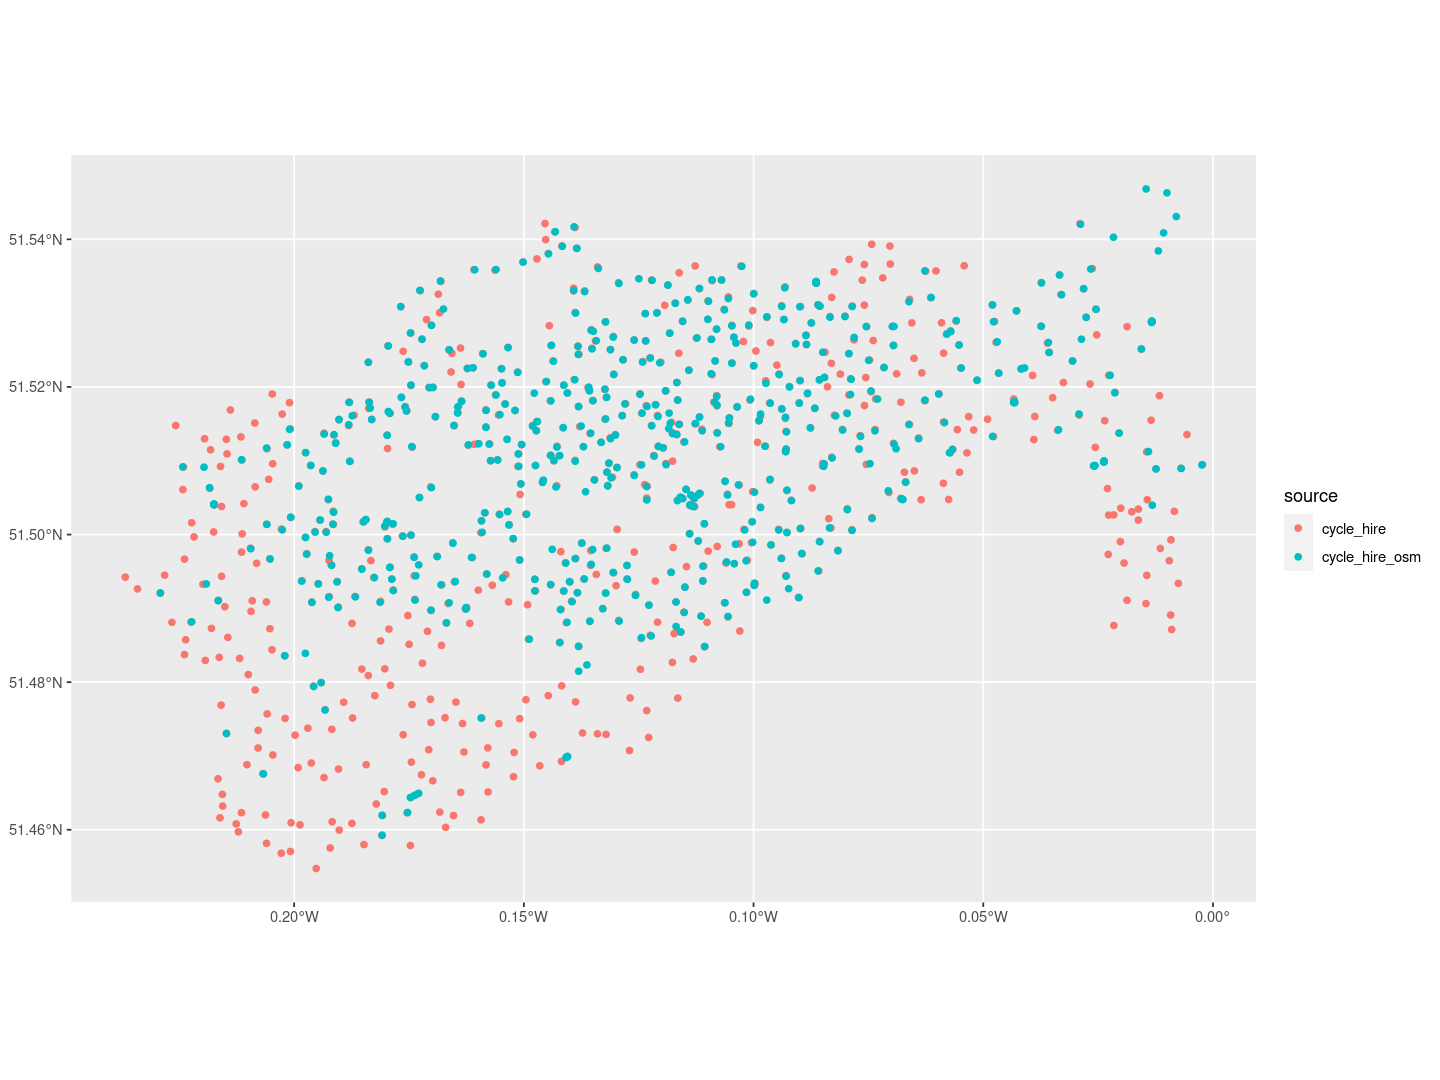

In [62]:
t1 <- cycle_hire %>%
    select(geometry) %>%
    mutate(source="cycle_hire")

t2 <- cycle_hire_osm %>%
    select(geometry) %>%
    mutate(source="cycle_hire_osm")

t1 %>%
    rbind(t2) %>%
    ggplot() +
    geom_sf(aes(col=source))

In [63]:
t1 %>% 
    st_join(t2, left=F)

source.x,source.y,geometry
<chr>,<chr>,<GEOMETRY [°]>


The points from the two datasets are disjoint.

Suppose we want to add the `capacity` information from `cycle_hire_osm` to `cycle_hire`. We can do so by defining a threshold distance and then apply spatial joining.



In [64]:
cycle_hire_P = st_transform(cycle_hire, 27700)
cycle_hire_osm_P = st_transform(cycle_hire_osm, 27700)


cycle_hire_P %>%
    st_crs()

Coordinate Reference System:
  User input: EPSG:27700 
  wkt:
PROJCRS["OSGB 1936 / British National Grid",
    BASEGEOGCRS["OSGB 1936",
        DATUM["OSGB 1936",
            ELLIPSOID["Airy 1830",6377563.396,299.3249646,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4277]],
    CONVERSION["British National Grid",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",49,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-2,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996012717,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",400000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER

In [65]:
cycle_hire_P %>%
    st_join(cycle_hire_osm_P, join = st_is_within_distance, dist = 20) %>%
    group_by(id) %>%
    summarize(capacity = mean(capacity, na.rm=T)) %>%
    st_drop_geometry() %>%
    inner_join(cycle_hire_P) %>%
    slice_sample(n=20)

Joining, by = "id"



id,capacity,name,area,nbikes,nempty,geometry
<int>,<dbl>,<fct>,<fct>,<int>,<int>,<POINT [m]>
82,NaN,Chancery Lane,Holborn,0,15,POINT (531157 181174)
450,NaN,Jubilee Street,Stepney,28,0,POINT (535181.8 181468.8)
425,NaN,Harrington Square 2,Camden Town,31,7,POINT (529167 183249)
37,7,Penywern Road,Earl's Court,15,2,POINT (525591.3 178509.8)
201,6,Dorset Square,Marylebone,15,0,POINT (527674.5 182011.4)
508,8,Fournier Street,Whitechapel,1,15,POINT (533697.3 181806.4)
380,11,Stanhope Gate,Mayfair,0,21,POINT (528443.4 180280.2)
110,7,Wellington Road,St. John's Wood,10,7,POINT (526853.6 183153.3)
123,8,St. John Street,Finsbury,5,13,POINT (531569.7 182752.1)
